In [1]:
alphabet = "ABCDEFGHIJKLMNOPQRSTVUWXYZ"

# Image Generation

In [2]:
import cairocffi as cairo
import random
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

np.random.seed(55)

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck


def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        # this font list works in CentOS 7
        if multi_fonts:
            fonts = [
                'Century Schoolbook', 'Courier', 'STIX',
                'URW Chancery L', 'FreeMono']
            context.select_font_face(
                np.random.choice(fonts),
                cairo.FONT_SLANT_NORMAL,
                np.random.choice([cairo.FONT_WEIGHT_BOLD, cairo.FONT_WEIGHT_NORMAL]))
        else:
            context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # teach the RNN translational invariance by
        # fitting text box randomly on canvas, with some room to rotate
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]  # grab single channel
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
    a = speckle(a)

    return a

def text_to_labels(text):
    labels = []

    for char in text:
        labels.append(alphabet.find(char))

    return np.array(labels)


def generate_text(text_length=3):
    chars = random.choices(alphabet, k=text_length)
    return "".join(chars)


def get_generator(width, height, input_length=0, text_length=3, batch_size=32):
    def generator():
        result = {
            "images": np.zeros((batch_size, height, width, 1), dtype=np.float32),
            "labels": np.zeros((batch_size, text_length)) * len(alphabet),
            "label_length": np.zeros((batch_size, 1)),
            "input_length": np.zeros((batch_size, 1))
        }        
        
        for i in range(batch_size):        
            text = generate_text(text_length)
            image = paint_text(text, width, height, rotate=False, multi_fonts=False)[0]
            image = np.expand_dims(image, axis=2)
            #image = np.reshape(image, (height, width, 1))
            #print(image.shape)
            
            result['input_length'][i, 0] = input_length
            result['label_length'][i, 0] = len(text) 
            result['labels'][i] = text_to_labels(text)
            result['images'][i] = image
            
        yield result
        
    return generator  

# Generate Examples 

In [3]:
HEIGHT = 64
WIDTH = 80
textgen = get_generator(WIDTH, HEIGHT, input_length=18, text_length=3, batch_size=32)

float32
(32, 64, 80, 1)


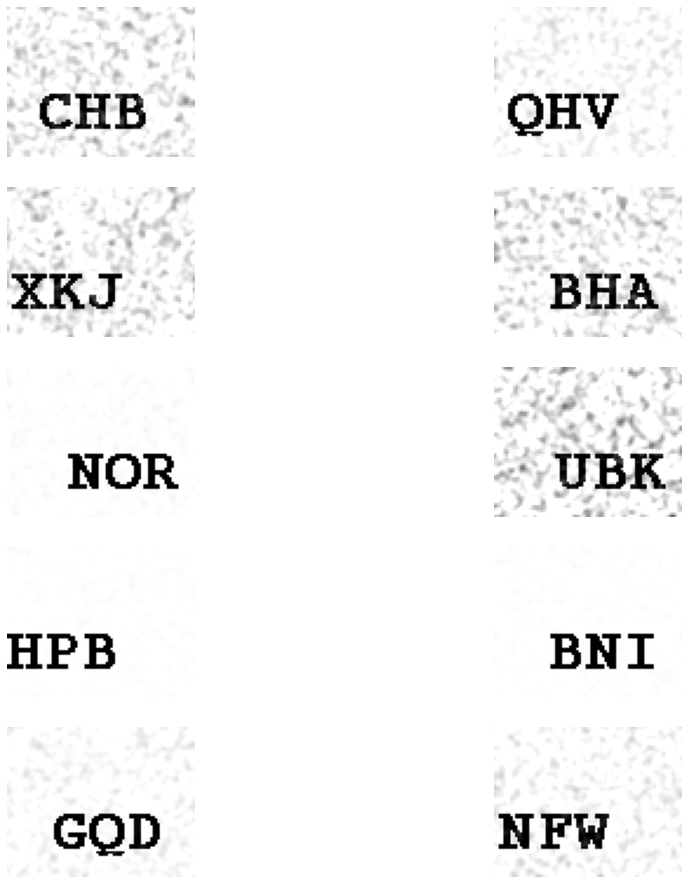

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(16, 16))

axes = axes.flatten()
batch = next(textgen())

print(batch['images'].dtype)
print(batch['images'].shape)

for index in range(10):
    axes[index].imshow(np.squeeze(batch['images'][index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, BatchNormalization, MaxPooling2D, Activation, Reshape, Permute, Bidirectional, LSTM, GRU, Dense, Add, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import SGD

# Show image preparation for network (permute + reverse)

(32, 80, 64, 1)


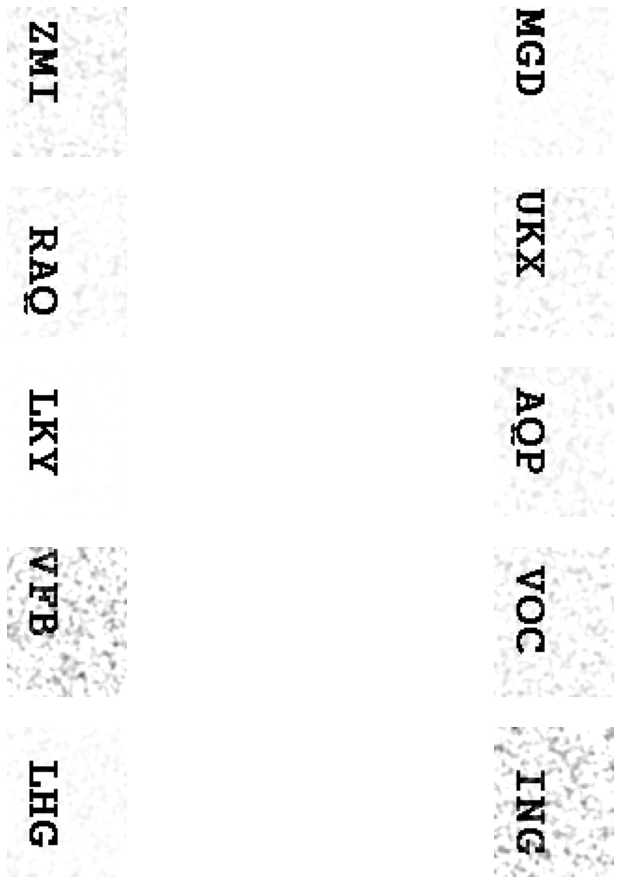

In [6]:
inputs = Input(shape=(HEIGHT, WIDTH, 1), name='input', dtype='float32')

# swap width/height dimension
permute = Permute((2, 1, 3))(inputs)

# reverse last channel to prevent mirroring
permute = Lambda(lambda x: x[:, :, ::-1])(permute)

test_permute_model = Model(inputs=inputs, outputs=permute)

result = test_permute_model(next(textgen()))
print(result.shape)

fig, axes = plt.subplots(5, 2, figsize=(16, 16))
axes = axes.flatten()

for index in range(10):
    axes[index].imshow(np.squeeze(result[index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()


# Create Network Architecture

In [7]:
inputs = Input(shape=(HEIGHT, WIDTH, 1), name='input', dtype='float32')

permute = Permute((2, 1, 3))(inputs)
permute = Lambda(lambda x: x[:, :, ::-1])(permute)

print("after permute", permute.shape)

block_1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(permute)
block_1 = MaxPooling2D((2, 2))(block_1)

block_2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(block_1)
block_2 = MaxPooling2D((2, 1))(block_2)

after_cnn = block_2
print("after cnn", after_cnn.shape)

reshape_conf = (after_cnn.shape[1], after_cnn.shape[2] * after_cnn.shape[3])
TIMESLOTS = after_cnn.shape[1]

after_reshape = Reshape(reshape_conf)(after_cnn)
print("after reshape", after_reshape.shape)

after_reshape = Dense(128, kernel_initializer='he_normal')(after_reshape)

block_rnn = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal'))(after_reshape)
block_rnn = Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='he_normal'))(block_rnn)
print("block rnn", block_rnn.shape)

dropout = Dropout(0.1)(block_rnn)

tokens = Dense(len(alphabet) + 1, kernel_initializer='he_normal')(dropout)
print("tokens", tokens.shape)

y_pred = Activation('softmax', name="y_activation")(tokens)
print("y pred", y_pred.shape)

pred_model = Model(inputs=inputs, outputs=y_pred)
pred_model.summary()

after permute (None, 80, 64, 1)
after cnn (None, 20, 32, 32)
after reshape (None, 20, 1024)
block rnn (None, 20, 256)
tokens (None, 20, 27)
y pred (None, 20, 27)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 80, 1)]       0         
_________________________________________________________________
permute_1 (Permute)          (None, 80, 64, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            

# Training

In [8]:
textgen = get_generator(WIDTH, HEIGHT, input_length=TIMESLOTS, text_length=3, batch_size=32)

STOP_AT_LOSS = 0.05
EPOCHS = 5000
TRAIN_STEPS = 50
VAL_STEPS = 10
TRAIN = True

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, clipvalue = 0.5)
optimizer = tf.keras.optimizers.Adadelta()
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
training_history = {
    "train_loss": [],
    "val_loss": []
}

def train_step(data):
    with tf.GradientTape() as tape:
        y_pred = pred_model(data['images'], training=True)
        loss = tf.keras.backend.ctc_batch_cost(data['labels'], y_pred, data['input_length'], data['label_length'])                
        gradients = tape.gradient(loss, pred_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pred_model.trainable_variables))
        train_loss_metric(loss)
        
def test_step(data):
        y_pred = pred_model(data['images'], training=False)
        loss = tf.keras.backend.ctc_batch_cost(data['labels'], y_pred, data['input_length'], data['label_length'])
        val_loss_metric(loss)

if TRAIN:
    epoch = 1
    while True:
        train_loss_metric.reset_states()
        val_loss_metric.reset_states()

        print("Start training epoch {}".format(epoch + 1))
        
        for step in range(TRAIN_STEPS):
            data = next(textgen())
            train_step(data)
            
        for step in range(VAL_STEPS):
            data = next(textgen())
            test_step(data)
            
        train_loss = train_loss_metric.result()
        val_loss = val_loss_metric.result()
            
        print("Train Loss: {}, Test Loss: {}".format(train_loss, val_loss))
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        
        if train_loss < STOP_AT_LOSS and val_loss < STOP_AT_LOSS:
            break
        
        epoch += 1
        
    

Start training epoch 2
Train Loss: 50.851261138916016, Test Loss: 47.02132797241211
Start training epoch 3
Train Loss: 42.49333190917969, Test Loss: 37.834808349609375
Start training epoch 4
Train Loss: 33.550968170166016, Test Loss: 29.175012588500977
Start training epoch 5
Train Loss: 25.929981231689453, Test Loss: 22.723388671875
Start training epoch 6
Train Loss: 20.385196685791016, Test Loss: 17.94040298461914
Start training epoch 7
Train Loss: 16.267210006713867, Test Loss: 14.605695724487305
Start training epoch 8
Train Loss: 13.76066780090332, Test Loss: 12.892511367797852
Start training epoch 9
Train Loss: 12.5462007522583, Test Loss: 12.138626098632812
Start training epoch 10
Train Loss: 11.932995796203613, Test Loss: 11.728472709655762
Start training epoch 11
Train Loss: 11.62610149383545, Test Loss: 11.500853538513184
Start training epoch 12
Train Loss: 11.45663833618164, Test Loss: 11.304401397705078
Start training epoch 13
Train Loss: 11.322502136230469, Test Loss: 11.284

Train Loss: 10.9440279006958, Test Loss: 10.934572219848633
Start training epoch 99
Train Loss: 10.950499534606934, Test Loss: 10.931451797485352
Start training epoch 100
Train Loss: 10.942361831665039, Test Loss: 10.934382438659668
Start training epoch 101
Train Loss: 10.92458724975586, Test Loss: 10.916200637817383
Start training epoch 102
Train Loss: 10.928204536437988, Test Loss: 10.918035507202148
Start training epoch 103
Train Loss: 10.9232816696167, Test Loss: 10.906471252441406
Start training epoch 104
Train Loss: 10.926553726196289, Test Loss: 10.918649673461914
Start training epoch 105
Train Loss: 10.905078887939453, Test Loss: 10.927273750305176
Start training epoch 106
Train Loss: 10.914327621459961, Test Loss: 10.909698486328125
Start training epoch 107
Train Loss: 10.911090850830078, Test Loss: 10.879339218139648
Start training epoch 108
Train Loss: 10.894179344177246, Test Loss: 10.864358901977539
Start training epoch 109
Train Loss: 10.882462501525879, Test Loss: 10.879

Train Loss: 10.2626314163208, Test Loss: 10.173776626586914
Start training epoch 194
Train Loss: 10.250662803649902, Test Loss: 10.192479133605957
Start training epoch 195
Train Loss: 10.241861343383789, Test Loss: 10.208727836608887
Start training epoch 196
Train Loss: 10.241277694702148, Test Loss: 10.22096061706543
Start training epoch 197
Train Loss: 10.237220764160156, Test Loss: 10.215624809265137
Start training epoch 198
Train Loss: 10.225650787353516, Test Loss: 10.184980392456055
Start training epoch 199
Train Loss: 10.218445777893066, Test Loss: 10.152152061462402
Start training epoch 200
Train Loss: 10.20591926574707, Test Loss: 10.192258834838867
Start training epoch 201
Train Loss: 10.212156295776367, Test Loss: 10.195060729980469
Start training epoch 202
Train Loss: 10.185999870300293, Test Loss: 10.10727596282959
Start training epoch 203
Train Loss: 10.182624816894531, Test Loss: 10.157882690429688
Start training epoch 204
Train Loss: 10.228565216064453, Test Loss: 10.10

Train Loss: 9.681107521057129, Test Loss: 9.573283195495605
Start training epoch 290
Train Loss: 9.617667198181152, Test Loss: 9.532188415527344
Start training epoch 291
Train Loss: 9.6355619430542, Test Loss: 9.608468055725098
Start training epoch 292
Train Loss: 9.613329887390137, Test Loss: 9.551135063171387
Start training epoch 293
Train Loss: 9.602944374084473, Test Loss: 9.578580856323242
Start training epoch 294
Train Loss: 9.590909004211426, Test Loss: 9.49409008026123
Start training epoch 295
Train Loss: 9.587348937988281, Test Loss: 9.563801765441895
Start training epoch 296
Train Loss: 9.612738609313965, Test Loss: 9.491687774658203
Start training epoch 297
Train Loss: 9.571708679199219, Test Loss: 9.663488388061523
Start training epoch 298
Train Loss: 9.595512390136719, Test Loss: 9.568211555480957
Start training epoch 299
Train Loss: 9.600676536560059, Test Loss: 9.445526123046875
Start training epoch 300
Train Loss: 9.567204475402832, Test Loss: 9.578256607055664
Start tr

Train Loss: 9.070235252380371, Test Loss: 9.049307823181152
Start training epoch 387
Train Loss: 9.059502601623535, Test Loss: 9.113779067993164
Start training epoch 388
Train Loss: 8.989375114440918, Test Loss: 8.984225273132324
Start training epoch 389
Train Loss: 9.084822654724121, Test Loss: 8.920430183410645
Start training epoch 390
Train Loss: 8.988141059875488, Test Loss: 8.9375638961792
Start training epoch 391
Train Loss: 9.021710395812988, Test Loss: 9.054414749145508
Start training epoch 392
Train Loss: 9.057989120483398, Test Loss: 8.98962116241455
Start training epoch 393
Train Loss: 9.020294189453125, Test Loss: 8.943283081054688
Start training epoch 394
Train Loss: 9.045839309692383, Test Loss: 8.936494827270508
Start training epoch 395
Train Loss: 9.042206764221191, Test Loss: 9.027152061462402
Start training epoch 396
Train Loss: 8.998061180114746, Test Loss: 9.01059341430664
Start training epoch 397
Train Loss: 8.994963645935059, Test Loss: 9.009387016296387
Start tra

Train Loss: 8.524829864501953, Test Loss: 8.522997856140137
Start training epoch 484
Train Loss: 8.497286796569824, Test Loss: 8.518129348754883
Start training epoch 485
Train Loss: 8.509737014770508, Test Loss: 8.569991111755371
Start training epoch 486
Train Loss: 8.549976348876953, Test Loss: 8.375249862670898
Start training epoch 487
Train Loss: 8.542129516601562, Test Loss: 8.541790008544922
Start training epoch 488
Train Loss: 8.491716384887695, Test Loss: 8.430501937866211
Start training epoch 489
Train Loss: 8.517518043518066, Test Loss: 8.397839546203613
Start training epoch 490
Train Loss: 8.54821491241455, Test Loss: 8.417505264282227
Start training epoch 491
Train Loss: 8.590065002441406, Test Loss: 8.42033863067627
Start training epoch 492
Train Loss: 8.46319580078125, Test Loss: 8.426071166992188
Start training epoch 493
Train Loss: 8.496496200561523, Test Loss: 8.450616836547852
Start training epoch 494
Train Loss: 8.519200325012207, Test Loss: 8.458552360534668
Start tr

Train Loss: 8.101770401000977, Test Loss: 8.066102981567383
Start training epoch 581
Train Loss: 8.056899070739746, Test Loss: 8.01854133605957
Start training epoch 582
Train Loss: 8.084102630615234, Test Loss: 7.984921455383301
Start training epoch 583
Train Loss: 8.054582595825195, Test Loss: 8.06908130645752
Start training epoch 584
Train Loss: 8.042900085449219, Test Loss: 7.914641380310059
Start training epoch 585
Train Loss: 8.08586597442627, Test Loss: 8.117830276489258
Start training epoch 586
Train Loss: 8.042316436767578, Test Loss: 7.9470977783203125
Start training epoch 587
Train Loss: 8.097238540649414, Test Loss: 8.044473648071289
Start training epoch 588
Train Loss: 8.084371566772461, Test Loss: 7.945122718811035
Start training epoch 589
Train Loss: 8.084943771362305, Test Loss: 7.99321985244751
Start training epoch 590
Train Loss: 8.069143295288086, Test Loss: 7.914469242095947
Start training epoch 591
Train Loss: 8.024097442626953, Test Loss: 7.885836124420166
Start tr

Train Loss: 7.679676055908203, Test Loss: 7.611602783203125
Start training epoch 678
Train Loss: 7.700109481811523, Test Loss: 7.676604270935059
Start training epoch 679
Train Loss: 7.726034164428711, Test Loss: 7.596490383148193
Start training epoch 680
Train Loss: 7.733008861541748, Test Loss: 7.638144016265869
Start training epoch 681
Train Loss: 7.671324253082275, Test Loss: 7.69314432144165
Start training epoch 682
Train Loss: 7.707187652587891, Test Loss: 7.645811557769775
Start training epoch 683
Train Loss: 7.684990882873535, Test Loss: 7.597458839416504
Start training epoch 684
Train Loss: 7.7306389808654785, Test Loss: 7.6405348777771
Start training epoch 685
Train Loss: 7.634178638458252, Test Loss: 7.6198883056640625
Start training epoch 686
Train Loss: 7.68170166015625, Test Loss: 7.6433281898498535
Start training epoch 687
Train Loss: 7.661062240600586, Test Loss: 7.64151668548584
Start training epoch 688
Train Loss: 7.678480625152588, Test Loss: 7.581704616546631
Start t

Train Loss: 7.405975818634033, Test Loss: 7.2891740798950195
Start training epoch 775
Train Loss: 7.3301005363464355, Test Loss: 7.389904022216797
Start training epoch 776
Train Loss: 7.343751430511475, Test Loss: 7.313785552978516
Start training epoch 777
Train Loss: 7.377705097198486, Test Loss: 7.245582580566406
Start training epoch 778
Train Loss: 7.390637397766113, Test Loss: 7.493582725524902
Start training epoch 779
Train Loss: 7.351370334625244, Test Loss: 7.306746006011963
Start training epoch 780
Train Loss: 7.378811836242676, Test Loss: 7.297072410583496
Start training epoch 781
Train Loss: 7.339940071105957, Test Loss: 7.280185699462891
Start training epoch 782
Train Loss: 7.339714527130127, Test Loss: 7.301546573638916
Start training epoch 783
Train Loss: 7.343380928039551, Test Loss: 7.306779384613037
Start training epoch 784
Train Loss: 7.358273983001709, Test Loss: 7.080225467681885
Start training epoch 785
Train Loss: 7.326315402984619, Test Loss: 7.3211846351623535
St

Train Loss: 7.1197123527526855, Test Loss: 7.0181756019592285
Start training epoch 872
Train Loss: 7.099837779998779, Test Loss: 7.080774784088135
Start training epoch 873
Train Loss: 7.061010837554932, Test Loss: 6.95059871673584
Start training epoch 874
Train Loss: 7.143931865692139, Test Loss: 7.053765296936035
Start training epoch 875
Train Loss: 7.061593055725098, Test Loss: 6.960949897766113
Start training epoch 876
Train Loss: 7.065447807312012, Test Loss: 7.029595375061035
Start training epoch 877
Train Loss: 7.063206195831299, Test Loss: 6.978812217712402
Start training epoch 878
Train Loss: 7.092465400695801, Test Loss: 7.151985168457031
Start training epoch 879
Train Loss: 7.1032185554504395, Test Loss: 7.067952632904053
Start training epoch 880
Train Loss: 7.1181721687316895, Test Loss: 7.082608222961426
Start training epoch 881
Train Loss: 7.0253801345825195, Test Loss: 6.921350002288818
Start training epoch 882
Train Loss: 7.062539577484131, Test Loss: 6.93630838394165
St

Train Loss: 6.854794979095459, Test Loss: 6.919807434082031
Start training epoch 969
Train Loss: 6.819412708282471, Test Loss: 6.78866720199585
Start training epoch 970
Train Loss: 6.836645603179932, Test Loss: 6.705699920654297
Start training epoch 971
Train Loss: 6.834166049957275, Test Loss: 6.778563499450684
Start training epoch 972
Train Loss: 6.7823028564453125, Test Loss: 6.749639987945557
Start training epoch 973
Train Loss: 6.855867862701416, Test Loss: 6.756522178649902
Start training epoch 974
Train Loss: 6.827886581420898, Test Loss: 6.777588844299316
Start training epoch 975
Train Loss: 6.869049549102783, Test Loss: 6.828434944152832
Start training epoch 976
Train Loss: 6.858004570007324, Test Loss: 6.853752136230469
Start training epoch 977
Train Loss: 6.84197998046875, Test Loss: 6.814618110656738
Start training epoch 978
Train Loss: 6.879671096801758, Test Loss: 6.806677341461182
Start training epoch 979
Train Loss: 6.817229747772217, Test Loss: 6.758506774902344
Start 

Train Loss: 6.694911003112793, Test Loss: 6.599787712097168
Start training epoch 1065
Train Loss: 6.620944023132324, Test Loss: 6.599329471588135
Start training epoch 1066
Train Loss: 6.671530246734619, Test Loss: 6.636346340179443
Start training epoch 1067
Train Loss: 6.6171488761901855, Test Loss: 6.4954328536987305
Start training epoch 1068
Train Loss: 6.6742024421691895, Test Loss: 6.530086517333984
Start training epoch 1069
Train Loss: 6.633192539215088, Test Loss: 6.574378967285156
Start training epoch 1070
Train Loss: 6.649538993835449, Test Loss: 6.538941860198975
Start training epoch 1071
Train Loss: 6.634793758392334, Test Loss: 6.486436367034912
Start training epoch 1072
Train Loss: 6.665267467498779, Test Loss: 6.672576904296875
Start training epoch 1073
Train Loss: 6.683431625366211, Test Loss: 6.6053266525268555
Start training epoch 1074
Train Loss: 6.583278656005859, Test Loss: 6.56986141204834
Start training epoch 1075
Train Loss: 6.631170272827148, Test Loss: 6.4762625

Train Loss: 6.456794261932373, Test Loss: 6.37589693069458
Start training epoch 1161
Train Loss: 6.4751129150390625, Test Loss: 6.537837028503418
Start training epoch 1162
Train Loss: 6.4422688484191895, Test Loss: 6.422259330749512
Start training epoch 1163
Train Loss: 6.410886287689209, Test Loss: 6.242101669311523
Start training epoch 1164
Train Loss: 6.524053573608398, Test Loss: 6.2655439376831055
Start training epoch 1165
Train Loss: 6.464840888977051, Test Loss: 6.342406272888184
Start training epoch 1166
Train Loss: 6.475147724151611, Test Loss: 6.347041130065918
Start training epoch 1167
Train Loss: 6.423808574676514, Test Loss: 6.375667095184326
Start training epoch 1168
Train Loss: 6.402448654174805, Test Loss: 6.393406391143799
Start training epoch 1169
Train Loss: 6.3969197273254395, Test Loss: 6.45504903793335
Start training epoch 1170
Train Loss: 6.402759552001953, Test Loss: 6.402915954589844
Start training epoch 1171
Train Loss: 6.434107780456543, Test Loss: 6.50857448

Train Loss: 6.304062366485596, Test Loss: 6.294297218322754
Start training epoch 1257
Train Loss: 6.316585540771484, Test Loss: 6.190802574157715
Start training epoch 1258
Train Loss: 6.3160810470581055, Test Loss: 6.358115196228027
Start training epoch 1259
Train Loss: 6.326400279998779, Test Loss: 6.379262447357178
Start training epoch 1260
Train Loss: 6.323831081390381, Test Loss: 6.146618843078613
Start training epoch 1261
Train Loss: 6.248637676239014, Test Loss: 6.204872131347656
Start training epoch 1262
Train Loss: 6.283214092254639, Test Loss: 6.230659484863281
Start training epoch 1263
Train Loss: 6.286117076873779, Test Loss: 6.194766998291016
Start training epoch 1264
Train Loss: 6.264951705932617, Test Loss: 6.239161014556885
Start training epoch 1265
Train Loss: 6.272207736968994, Test Loss: 6.201718330383301
Start training epoch 1266
Train Loss: 6.320866584777832, Test Loss: 6.341633319854736
Start training epoch 1267
Train Loss: 6.298812389373779, Test Loss: 6.276017665

Train Loss: 6.168971538543701, Test Loss: 5.943048477172852
Start training epoch 1353
Train Loss: 6.1486077308654785, Test Loss: 6.16898250579834
Start training epoch 1354
Train Loss: 6.1432318687438965, Test Loss: 6.0953521728515625
Start training epoch 1355
Train Loss: 6.1667022705078125, Test Loss: 6.047482967376709
Start training epoch 1356
Train Loss: 6.129205226898193, Test Loss: 6.055649757385254
Start training epoch 1357
Train Loss: 6.136187553405762, Test Loss: 6.032753944396973
Start training epoch 1358
Train Loss: 6.146306037902832, Test Loss: 6.0830535888671875
Start training epoch 1359
Train Loss: 6.125595569610596, Test Loss: 6.156411170959473
Start training epoch 1360
Train Loss: 6.1769700050354, Test Loss: 6.059361457824707
Start training epoch 1361
Train Loss: 6.159688949584961, Test Loss: 6.113246917724609
Start training epoch 1362
Train Loss: 6.140737533569336, Test Loss: 6.129823684692383
Start training epoch 1363
Train Loss: 6.04617166519165, Test Loss: 5.955161094

Train Loss: 6.01963996887207, Test Loss: 6.0469207763671875
Start training epoch 1449
Train Loss: 5.986570358276367, Test Loss: 6.009760856628418
Start training epoch 1450
Train Loss: 6.045651435852051, Test Loss: 5.863716125488281
Start training epoch 1451
Train Loss: 5.950356483459473, Test Loss: 5.899106025695801
Start training epoch 1452
Train Loss: 5.989631175994873, Test Loss: 5.783627033233643
Start training epoch 1453
Train Loss: 5.995090961456299, Test Loss: 5.860556602478027
Start training epoch 1454
Train Loss: 5.9987664222717285, Test Loss: 5.964383125305176
Start training epoch 1455
Train Loss: 5.976922512054443, Test Loss: 5.97813081741333
Start training epoch 1456
Train Loss: 6.001572132110596, Test Loss: 6.0781965255737305
Start training epoch 1457
Train Loss: 6.031937122344971, Test Loss: 5.987512111663818
Start training epoch 1458
Train Loss: 6.0214033126831055, Test Loss: 5.96779727935791
Start training epoch 1459
Train Loss: 5.998973369598389, Test Loss: 6.014252662

Train Loss: 5.854962348937988, Test Loss: 5.824146270751953
Start training epoch 1545
Train Loss: 5.894919395446777, Test Loss: 5.905688285827637
Start training epoch 1546
Train Loss: 5.833613395690918, Test Loss: 5.774809837341309
Start training epoch 1547
Train Loss: 5.887197971343994, Test Loss: 5.854430198669434
Start training epoch 1548
Train Loss: 5.885357856750488, Test Loss: 5.8505167961120605
Start training epoch 1549
Train Loss: 5.806902885437012, Test Loss: 5.9153032302856445
Start training epoch 1550
Train Loss: 5.838984489440918, Test Loss: 5.857347011566162
Start training epoch 1551
Train Loss: 5.838220119476318, Test Loss: 5.8358235359191895
Start training epoch 1552
Train Loss: 5.863701820373535, Test Loss: 5.738430976867676
Start training epoch 1553
Train Loss: 5.884133815765381, Test Loss: 5.7854108810424805
Start training epoch 1554
Train Loss: 5.808689594268799, Test Loss: 5.794594764709473
Start training epoch 1555
Train Loss: 5.820990562438965, Test Loss: 5.695695

Train Loss: 5.706051826477051, Test Loss: 5.7114105224609375
Start training epoch 1641
Train Loss: 5.757712364196777, Test Loss: 5.663906574249268
Start training epoch 1642
Train Loss: 5.678958892822266, Test Loss: 5.686341762542725
Start training epoch 1643
Train Loss: 5.766961097717285, Test Loss: 5.6804585456848145
Start training epoch 1644
Train Loss: 5.781558990478516, Test Loss: 5.648993492126465
Start training epoch 1645
Train Loss: 5.744831562042236, Test Loss: 5.667920112609863
Start training epoch 1646
Train Loss: 5.694310188293457, Test Loss: 5.6567816734313965
Start training epoch 1647
Train Loss: 5.7584357261657715, Test Loss: 5.63938045501709
Start training epoch 1648
Train Loss: 5.777766704559326, Test Loss: 5.596465110778809
Start training epoch 1649
Train Loss: 5.735815048217773, Test Loss: 5.670886039733887
Start training epoch 1650
Train Loss: 5.763032913208008, Test Loss: 5.64608097076416
Start training epoch 1651
Train Loss: 5.749320030212402, Test Loss: 5.75903606

Train Loss: 5.682244777679443, Test Loss: 5.634861469268799
Start training epoch 1737
Train Loss: 5.605327129364014, Test Loss: 5.580837249755859
Start training epoch 1738
Train Loss: 5.6740899085998535, Test Loss: 5.6673502922058105
Start training epoch 1739
Train Loss: 5.661823749542236, Test Loss: 5.490225791931152
Start training epoch 1740
Train Loss: 5.6141037940979, Test Loss: 5.629912376403809
Start training epoch 1741
Train Loss: 5.650334358215332, Test Loss: 5.609622001647949
Start training epoch 1742
Train Loss: 5.607727527618408, Test Loss: 5.5906758308410645
Start training epoch 1743
Train Loss: 5.604551315307617, Test Loss: 5.631472587585449
Start training epoch 1744
Train Loss: 5.6802897453308105, Test Loss: 5.473613262176514
Start training epoch 1745
Train Loss: 5.6523566246032715, Test Loss: 5.457282066345215
Start training epoch 1746
Train Loss: 5.641981601715088, Test Loss: 5.540838241577148
Start training epoch 1747
Train Loss: 5.605795383453369, Test Loss: 5.6924805

Train Loss: 5.512423038482666, Test Loss: 5.501936912536621
Start training epoch 1833
Train Loss: 5.520890712738037, Test Loss: 5.501156806945801
Start training epoch 1834
Train Loss: 5.5399065017700195, Test Loss: 5.432398796081543
Start training epoch 1835
Train Loss: 5.560732364654541, Test Loss: 5.402541160583496
Start training epoch 1836
Train Loss: 5.506059646606445, Test Loss: 5.500500202178955
Start training epoch 1837
Train Loss: 5.574404716491699, Test Loss: 5.5112152099609375
Start training epoch 1838
Train Loss: 5.508471488952637, Test Loss: 5.360567569732666
Start training epoch 1839
Train Loss: 5.53842306137085, Test Loss: 5.5206298828125
Start training epoch 1840
Train Loss: 5.569162368774414, Test Loss: 5.3582258224487305
Start training epoch 1841
Train Loss: 5.583209037780762, Test Loss: 5.467184066772461
Start training epoch 1842
Train Loss: 5.544792652130127, Test Loss: 5.4918365478515625
Start training epoch 1843
Train Loss: 5.543816089630127, Test Loss: 5.441092491

Train Loss: 5.423684597015381, Test Loss: 5.428249359130859
Start training epoch 1929
Train Loss: 5.4665656089782715, Test Loss: 5.40529203414917
Start training epoch 1930
Train Loss: 5.439985752105713, Test Loss: 5.409975528717041
Start training epoch 1931
Train Loss: 5.414824962615967, Test Loss: 5.339846134185791
Start training epoch 1932
Train Loss: 5.466419219970703, Test Loss: 5.372979164123535
Start training epoch 1933
Train Loss: 5.4250054359436035, Test Loss: 5.361738204956055
Start training epoch 1934
Train Loss: 5.417789459228516, Test Loss: 5.34320068359375
Start training epoch 1935
Train Loss: 5.472308158874512, Test Loss: 5.353266716003418
Start training epoch 1936
Train Loss: 5.428986072540283, Test Loss: 5.46054220199585
Start training epoch 1937
Train Loss: 5.447227954864502, Test Loss: 5.3064866065979
Start training epoch 1938
Train Loss: 5.431718349456787, Test Loss: 5.333127021789551
Start training epoch 1939
Train Loss: 5.440797328948975, Test Loss: 5.4178695678710

Train Loss: 5.325809478759766, Test Loss: 5.300149917602539
Start training epoch 2025
Train Loss: 5.341147422790527, Test Loss: 5.102874755859375
Start training epoch 2026
Train Loss: 5.327093601226807, Test Loss: 5.348794460296631
Start training epoch 2027
Train Loss: 5.375389575958252, Test Loss: 5.210215091705322
Start training epoch 2028
Train Loss: 5.342741012573242, Test Loss: 5.276667594909668
Start training epoch 2029
Train Loss: 5.345017910003662, Test Loss: 5.219432830810547
Start training epoch 2030
Train Loss: 5.370948314666748, Test Loss: 5.3465986251831055
Start training epoch 2031
Train Loss: 5.264249324798584, Test Loss: 5.351020336151123
Start training epoch 2032
Train Loss: 5.319058895111084, Test Loss: 5.266270160675049
Start training epoch 2033
Train Loss: 5.338293552398682, Test Loss: 5.333072662353516
Start training epoch 2034
Train Loss: 5.287686824798584, Test Loss: 5.211689472198486
Start training epoch 2035
Train Loss: 5.339288711547852, Test Loss: 5.300341129

Train Loss: 5.233171463012695, Test Loss: 5.219185829162598
Start training epoch 2121
Train Loss: 5.223565101623535, Test Loss: 5.078103542327881
Start training epoch 2122
Train Loss: 5.245233535766602, Test Loss: 5.2166266441345215
Start training epoch 2123
Train Loss: 5.240114212036133, Test Loss: 5.228824138641357
Start training epoch 2124
Train Loss: 5.2406535148620605, Test Loss: 5.224312782287598
Start training epoch 2125
Train Loss: 5.299756050109863, Test Loss: 5.1698126792907715
Start training epoch 2126
Train Loss: 5.137689590454102, Test Loss: 5.059961795806885
Start training epoch 2127
Train Loss: 5.221376419067383, Test Loss: 5.176762104034424
Start training epoch 2128
Train Loss: 5.236906051635742, Test Loss: 5.101850509643555
Start training epoch 2129
Train Loss: 5.21407413482666, Test Loss: 5.131738662719727
Start training epoch 2130
Train Loss: 5.18885612487793, Test Loss: 5.119929313659668
Start training epoch 2131
Train Loss: 5.241086959838867, Test Loss: 5.083709716

Train Loss: 5.134815216064453, Test Loss: 5.129620552062988
Start training epoch 2217
Train Loss: 5.1298627853393555, Test Loss: 5.097155570983887
Start training epoch 2218
Train Loss: 5.180123805999756, Test Loss: 5.0685601234436035
Start training epoch 2219
Train Loss: 5.162459850311279, Test Loss: 5.09244441986084
Start training epoch 2220
Train Loss: 5.097224235534668, Test Loss: 4.997422218322754
Start training epoch 2221
Train Loss: 5.1315155029296875, Test Loss: 5.019218444824219
Start training epoch 2222
Train Loss: 5.163614273071289, Test Loss: 5.127803325653076
Start training epoch 2223
Train Loss: 5.170029163360596, Test Loss: 5.1025710105896
Start training epoch 2224
Train Loss: 5.153336048126221, Test Loss: 5.046688556671143
Start training epoch 2225
Train Loss: 5.111535549163818, Test Loss: 5.092245578765869
Start training epoch 2226
Train Loss: 5.136773586273193, Test Loss: 5.15139627456665
Start training epoch 2227
Train Loss: 5.117340564727783, Test Loss: 4.97586917877

Train Loss: 5.014858245849609, Test Loss: 5.008795261383057
Start training epoch 2313
Train Loss: 5.0579094886779785, Test Loss: 4.998509407043457
Start training epoch 2314
Train Loss: 5.033669948577881, Test Loss: 5.018258571624756
Start training epoch 2315
Train Loss: 5.015389919281006, Test Loss: 5.000657081604004
Start training epoch 2316
Train Loss: 5.060272693634033, Test Loss: 5.048142910003662
Start training epoch 2317
Train Loss: 5.035877227783203, Test Loss: 4.953490257263184
Start training epoch 2318
Train Loss: 5.081003189086914, Test Loss: 5.037718772888184
Start training epoch 2319
Train Loss: 5.044672012329102, Test Loss: 5.088800430297852
Start training epoch 2320
Train Loss: 5.048703193664551, Test Loss: 4.976889133453369
Start training epoch 2321
Train Loss: 5.083456993103027, Test Loss: 4.972951889038086
Start training epoch 2322
Train Loss: 5.061007499694824, Test Loss: 5.026885032653809
Start training epoch 2323
Train Loss: 5.057887554168701, Test Loss: 4.930924892

Train Loss: 5.0112104415893555, Test Loss: 4.917162895202637
Start training epoch 2409
Train Loss: 4.918031215667725, Test Loss: 4.884968280792236
Start training epoch 2410
Train Loss: 5.007442951202393, Test Loss: 4.85320520401001
Start training epoch 2411
Train Loss: 4.972223281860352, Test Loss: 4.944892406463623
Start training epoch 2412
Train Loss: 4.9850287437438965, Test Loss: 4.877140998840332
Start training epoch 2413
Train Loss: 4.995165824890137, Test Loss: 4.912493705749512
Start training epoch 2414
Train Loss: 4.948195934295654, Test Loss: 4.901057243347168
Start training epoch 2415
Train Loss: 4.954347133636475, Test Loss: 4.881545543670654
Start training epoch 2416
Train Loss: 4.942090034484863, Test Loss: 4.870041847229004
Start training epoch 2417
Train Loss: 4.980410575866699, Test Loss: 4.701744556427002
Start training epoch 2418
Train Loss: 4.997135162353516, Test Loss: 4.987085342407227
Start training epoch 2419
Train Loss: 4.936148166656494, Test Loss: 4.812640666

Train Loss: 4.832961082458496, Test Loss: 4.8057050704956055
Start training epoch 2505
Train Loss: 4.866959095001221, Test Loss: 4.874729156494141
Start training epoch 2506
Train Loss: 4.882028579711914, Test Loss: 4.854067325592041
Start training epoch 2507
Train Loss: 4.8500518798828125, Test Loss: 4.7645487785339355
Start training epoch 2508
Train Loss: 4.879921913146973, Test Loss: 4.750332832336426
Start training epoch 2509
Train Loss: 4.853617191314697, Test Loss: 4.883037090301514
Start training epoch 2510
Train Loss: 4.880827903747559, Test Loss: 4.783548831939697
Start training epoch 2511
Train Loss: 4.904155731201172, Test Loss: 4.747044563293457
Start training epoch 2512
Train Loss: 4.885648727416992, Test Loss: 4.901963233947754
Start training epoch 2513
Train Loss: 4.825152397155762, Test Loss: 4.823708534240723
Start training epoch 2514
Train Loss: 4.8678388595581055, Test Loss: 4.909361839294434
Start training epoch 2515
Train Loss: 4.877565383911133, Test Loss: 4.722704

Train Loss: 4.7974324226379395, Test Loss: 4.742236137390137
Start training epoch 2601
Train Loss: 4.7718186378479, Test Loss: 4.779868125915527
Start training epoch 2602
Train Loss: 4.7799787521362305, Test Loss: 4.7643632888793945
Start training epoch 2603
Train Loss: 4.865577220916748, Test Loss: 4.7934675216674805
Start training epoch 2604
Train Loss: 4.815267562866211, Test Loss: 4.765917778015137
Start training epoch 2605
Train Loss: 4.812389850616455, Test Loss: 4.799407005310059
Start training epoch 2606
Train Loss: 4.847606182098389, Test Loss: 4.745473861694336
Start training epoch 2607
Train Loss: 4.779531955718994, Test Loss: 4.715437889099121
Start training epoch 2608
Train Loss: 4.828330993652344, Test Loss: 4.762380123138428
Start training epoch 2609
Train Loss: 4.823383331298828, Test Loss: 4.759083271026611
Start training epoch 2610
Train Loss: 4.812914848327637, Test Loss: 4.721188068389893
Start training epoch 2611
Train Loss: 4.78429651260376, Test Loss: 4.649010658

Train Loss: 4.708132743835449, Test Loss: 4.634678840637207
Start training epoch 2697
Train Loss: 4.714874744415283, Test Loss: 4.655755043029785
Start training epoch 2698
Train Loss: 4.694066524505615, Test Loss: 4.682336330413818
Start training epoch 2699
Train Loss: 4.6840715408325195, Test Loss: 4.688884258270264
Start training epoch 2700
Train Loss: 4.700504302978516, Test Loss: 4.586942195892334
Start training epoch 2701
Train Loss: 4.74250602722168, Test Loss: 4.750954627990723
Start training epoch 2702
Train Loss: 4.753918647766113, Test Loss: 4.725655555725098
Start training epoch 2703
Train Loss: 4.716220855712891, Test Loss: 4.605893135070801
Start training epoch 2704
Train Loss: 4.707761764526367, Test Loss: 4.697344779968262
Start training epoch 2705
Train Loss: 4.722346782684326, Test Loss: 4.6737236976623535
Start training epoch 2706
Train Loss: 4.694911956787109, Test Loss: 4.675122261047363
Start training epoch 2707
Train Loss: 4.686769008636475, Test Loss: 4.578272819

Train Loss: 4.623812675476074, Test Loss: 4.531654357910156
Start training epoch 2793
Train Loss: 4.58052396774292, Test Loss: 4.528350830078125
Start training epoch 2794
Train Loss: 4.569303512573242, Test Loss: 4.583038806915283
Start training epoch 2795
Train Loss: 4.616626739501953, Test Loss: 4.574877738952637
Start training epoch 2796
Train Loss: 4.666138172149658, Test Loss: 4.551427841186523
Start training epoch 2797
Train Loss: 4.658855438232422, Test Loss: 4.55191707611084
Start training epoch 2798
Train Loss: 4.629015922546387, Test Loss: 4.57196569442749
Start training epoch 2799
Train Loss: 4.639135837554932, Test Loss: 4.729119300842285
Start training epoch 2800
Train Loss: 4.683838844299316, Test Loss: 4.526088714599609
Start training epoch 2801
Train Loss: 4.631451606750488, Test Loss: 4.547859191894531
Start training epoch 2802
Train Loss: 4.567803859710693, Test Loss: 4.526833534240723
Start training epoch 2803
Train Loss: 4.6891679763793945, Test Loss: 4.546387672424

Train Loss: 4.543598175048828, Test Loss: 4.607168674468994
Start training epoch 2889
Train Loss: 4.523228168487549, Test Loss: 4.555781364440918
Start training epoch 2890
Train Loss: 4.549979209899902, Test Loss: 4.367453575134277
Start training epoch 2891
Train Loss: 4.565016269683838, Test Loss: 4.437958717346191
Start training epoch 2892
Train Loss: 4.5542426109313965, Test Loss: 4.5370564460754395
Start training epoch 2893
Train Loss: 4.565638542175293, Test Loss: 4.447203636169434
Start training epoch 2894
Train Loss: 4.586790561676025, Test Loss: 4.513768196105957
Start training epoch 2895
Train Loss: 4.5948567390441895, Test Loss: 4.60478401184082
Start training epoch 2896
Train Loss: 4.594412326812744, Test Loss: 4.5238261222839355
Start training epoch 2897
Train Loss: 4.554712772369385, Test Loss: 4.467396259307861
Start training epoch 2898
Train Loss: 4.565844535827637, Test Loss: 4.448269844055176
Start training epoch 2899
Train Loss: 4.579800605773926, Test Loss: 4.4874801

Train Loss: 4.503365993499756, Test Loss: 4.374693870544434
Start training epoch 2985
Train Loss: 4.463366985321045, Test Loss: 4.403088569641113
Start training epoch 2986
Train Loss: 4.438661098480225, Test Loss: 4.397172451019287
Start training epoch 2987
Train Loss: 4.437910079956055, Test Loss: 4.387631416320801
Start training epoch 2988
Train Loss: 4.456667900085449, Test Loss: 4.447673797607422
Start training epoch 2989
Train Loss: 4.445953369140625, Test Loss: 4.419936656951904
Start training epoch 2990
Train Loss: 4.492120742797852, Test Loss: 4.461056232452393
Start training epoch 2991
Train Loss: 4.467350482940674, Test Loss: 4.424740314483643
Start training epoch 2992
Train Loss: 4.475693225860596, Test Loss: 4.474359512329102
Start training epoch 2993
Train Loss: 4.4679460525512695, Test Loss: 4.400975227355957
Start training epoch 2994
Train Loss: 4.46824836730957, Test Loss: 4.4200615882873535
Start training epoch 2995
Train Loss: 4.476548671722412, Test Loss: 4.498431682

Train Loss: 4.392868518829346, Test Loss: 4.343193531036377
Start training epoch 3081
Train Loss: 4.398187160491943, Test Loss: 4.304037570953369
Start training epoch 3082
Train Loss: 4.416309833526611, Test Loss: 4.268996238708496
Start training epoch 3083
Train Loss: 4.4250335693359375, Test Loss: 4.352309703826904
Start training epoch 3084
Train Loss: 4.409368991851807, Test Loss: 4.340240478515625
Start training epoch 3085
Train Loss: 4.397953987121582, Test Loss: 4.304085731506348
Start training epoch 3086
Train Loss: 4.354236602783203, Test Loss: 4.431346416473389
Start training epoch 3087
Train Loss: 4.333620071411133, Test Loss: 4.370327949523926
Start training epoch 3088
Train Loss: 4.402337551116943, Test Loss: 4.304821491241455
Start training epoch 3089
Train Loss: 4.408781051635742, Test Loss: 4.362372398376465
Start training epoch 3090
Train Loss: 4.3643269538879395, Test Loss: 4.257798194885254
Start training epoch 3091
Train Loss: 4.367791652679443, Test Loss: 4.40408945

Train Loss: 4.3062028884887695, Test Loss: 4.2998833656311035
Start training epoch 3177
Train Loss: 4.277111530303955, Test Loss: 4.3221116065979
Start training epoch 3178
Train Loss: 4.298252105712891, Test Loss: 4.225621700286865
Start training epoch 3179
Train Loss: 4.332703590393066, Test Loss: 4.201829433441162
Start training epoch 3180
Train Loss: 4.286281585693359, Test Loss: 4.3013715744018555
Start training epoch 3181
Train Loss: 4.251529693603516, Test Loss: 4.132748603820801
Start training epoch 3182
Train Loss: 4.280126571655273, Test Loss: 4.164738178253174
Start training epoch 3183
Train Loss: 4.2976765632629395, Test Loss: 4.282949924468994
Start training epoch 3184
Train Loss: 4.3086748123168945, Test Loss: 4.229839324951172
Start training epoch 3185
Train Loss: 4.293997764587402, Test Loss: 4.204360008239746
Start training epoch 3186
Train Loss: 4.237675189971924, Test Loss: 4.30048942565918
Start training epoch 3187
Train Loss: 4.3004069328308105, Test Loss: 4.1750726

Train Loss: 4.1857380867004395, Test Loss: 4.192444324493408
Start training epoch 3273
Train Loss: 4.181093215942383, Test Loss: 4.245070457458496
Start training epoch 3274
Train Loss: 4.215489387512207, Test Loss: 4.218563079833984
Start training epoch 3275
Train Loss: 4.222069263458252, Test Loss: 4.135290622711182
Start training epoch 3276
Train Loss: 4.268369674682617, Test Loss: 4.091917037963867
Start training epoch 3277
Train Loss: 4.20461368560791, Test Loss: 4.133485317230225
Start training epoch 3278
Train Loss: 4.199591159820557, Test Loss: 4.214393615722656
Start training epoch 3279
Train Loss: 4.1929121017456055, Test Loss: 4.176593780517578
Start training epoch 3280
Train Loss: 4.2062201499938965, Test Loss: 4.06099796295166
Start training epoch 3281
Train Loss: 4.231002330780029, Test Loss: 4.050535678863525
Start training epoch 3282
Train Loss: 4.212097644805908, Test Loss: 4.11397647857666
Start training epoch 3283
Train Loss: 4.197140693664551, Test Loss: 4.1782674789

Train Loss: 4.095353126525879, Test Loss: 4.138494968414307
Start training epoch 3369
Train Loss: 4.054408550262451, Test Loss: 4.196327209472656
Start training epoch 3370
Train Loss: 4.153889179229736, Test Loss: 4.1230292320251465
Start training epoch 3371
Train Loss: 4.1326704025268555, Test Loss: 4.046648979187012
Start training epoch 3372
Train Loss: 4.074835300445557, Test Loss: 4.0721635818481445
Start training epoch 3373
Train Loss: 4.110235691070557, Test Loss: 3.973670244216919
Start training epoch 3374
Train Loss: 4.105114936828613, Test Loss: 4.028764724731445
Start training epoch 3375
Train Loss: 4.093671798706055, Test Loss: 4.093697547912598
Start training epoch 3376
Train Loss: 4.082108974456787, Test Loss: 4.01926326751709
Start training epoch 3377
Train Loss: 4.108758449554443, Test Loss: 4.125589847564697
Start training epoch 3378
Train Loss: 4.098306655883789, Test Loss: 4.0312113761901855
Start training epoch 3379
Train Loss: 4.118770599365234, Test Loss: 4.0176687

Train Loss: 3.97587513923645, Test Loss: 3.898535966873169
Start training epoch 3464
Train Loss: 3.945359230041504, Test Loss: 3.8966758251190186
Start training epoch 3465
Train Loss: 3.9357357025146484, Test Loss: 4.031308174133301
Start training epoch 3466
Train Loss: 3.9708032608032227, Test Loss: 3.8818306922912598
Start training epoch 3467
Train Loss: 4.011436462402344, Test Loss: 3.9422783851623535
Start training epoch 3468
Train Loss: 3.9704227447509766, Test Loss: 3.8809235095977783
Start training epoch 3469
Train Loss: 3.956468105316162, Test Loss: 3.977285861968994
Start training epoch 3470
Train Loss: 3.959212303161621, Test Loss: 3.8532040119171143
Start training epoch 3471
Train Loss: 3.9262595176696777, Test Loss: 3.977372646331787
Start training epoch 3472
Train Loss: 3.98214054107666, Test Loss: 3.8658947944641113
Start training epoch 3473
Train Loss: 3.9536337852478027, Test Loss: 3.9174301624298096
Start training epoch 3474
Train Loss: 3.9540176391601562, Test Loss: 3

Train Loss: 3.7577381134033203, Test Loss: 3.6567158699035645
Start training epoch 3559
Train Loss: 3.7380685806274414, Test Loss: 3.6627278327941895
Start training epoch 3560
Train Loss: 3.750844955444336, Test Loss: 3.74873423576355
Start training epoch 3561
Train Loss: 3.737292528152466, Test Loss: 3.7229015827178955
Start training epoch 3562
Train Loss: 3.7487409114837646, Test Loss: 3.6399989128112793
Start training epoch 3563
Train Loss: 3.7504987716674805, Test Loss: 3.684980869293213
Start training epoch 3564
Train Loss: 3.696730375289917, Test Loss: 3.747277021408081
Start training epoch 3565
Train Loss: 3.7154695987701416, Test Loss: 3.713176727294922
Start training epoch 3566
Train Loss: 3.7217962741851807, Test Loss: 3.6128311157226562
Start training epoch 3567
Train Loss: 3.729804754257202, Test Loss: 3.7213752269744873
Start training epoch 3568
Train Loss: 3.718487024307251, Test Loss: 3.6714911460876465
Start training epoch 3569
Train Loss: 3.7388062477111816, Test Loss:

Train Loss: 3.5015618801116943, Test Loss: 3.5231220722198486
Start training epoch 3654
Train Loss: 3.4836995601654053, Test Loss: 3.48530912399292
Start training epoch 3655
Train Loss: 3.4852309226989746, Test Loss: 3.404273271560669
Start training epoch 3656
Train Loss: 3.4765634536743164, Test Loss: 3.413137912750244
Start training epoch 3657
Train Loss: 3.5108273029327393, Test Loss: 3.4555296897888184
Start training epoch 3658
Train Loss: 3.4892992973327637, Test Loss: 3.485337734222412
Start training epoch 3659
Train Loss: 3.4866771697998047, Test Loss: 3.445291519165039
Start training epoch 3660
Train Loss: 3.476752281188965, Test Loss: 3.4979732036590576
Start training epoch 3661
Train Loss: 3.5104334354400635, Test Loss: 3.490229845046997
Start training epoch 3662
Train Loss: 3.419260025024414, Test Loss: 3.54426646232605
Start training epoch 3663
Train Loss: 3.481355905532837, Test Loss: 3.4433085918426514
Start training epoch 3664
Train Loss: 3.474534273147583, Test Loss: 3.

Train Loss: 3.2147109508514404, Test Loss: 3.226917266845703
Start training epoch 3749
Train Loss: 3.2667908668518066, Test Loss: 3.165959596633911
Start training epoch 3750
Train Loss: 3.256983757019043, Test Loss: 3.2655041217803955
Start training epoch 3751
Train Loss: 3.2379119396209717, Test Loss: 3.159383535385132
Start training epoch 3752
Train Loss: 3.256324052810669, Test Loss: 3.183567762374878
Start training epoch 3753
Train Loss: 3.2300708293914795, Test Loss: 3.203512668609619
Start training epoch 3754
Train Loss: 3.2203054428100586, Test Loss: 3.1567368507385254
Start training epoch 3755
Train Loss: 3.2213385105133057, Test Loss: 3.167666435241699
Start training epoch 3756
Train Loss: 3.2052183151245117, Test Loss: 3.1090846061706543
Start training epoch 3757
Train Loss: 3.2553343772888184, Test Loss: 3.1684842109680176
Start training epoch 3758
Train Loss: 3.1923253536224365, Test Loss: 3.1455068588256836
Start training epoch 3759
Train Loss: 3.193225383758545, Test Loss

Train Loss: 3.0040600299835205, Test Loss: 2.8103809356689453
Start training epoch 3844
Train Loss: 2.9725024700164795, Test Loss: 2.9569528102874756
Start training epoch 3845
Train Loss: 2.9717319011688232, Test Loss: 2.9044744968414307
Start training epoch 3846
Train Loss: 2.964556932449341, Test Loss: 2.917215347290039
Start training epoch 3847
Train Loss: 2.9551892280578613, Test Loss: 2.903916120529175
Start training epoch 3848
Train Loss: 2.961604118347168, Test Loss: 2.8652641773223877
Start training epoch 3849
Train Loss: 2.9465646743774414, Test Loss: 2.8452889919281006
Start training epoch 3850
Train Loss: 2.9783763885498047, Test Loss: 2.9227488040924072
Start training epoch 3851
Train Loss: 2.9592723846435547, Test Loss: 2.903057098388672
Start training epoch 3852
Train Loss: 2.9242703914642334, Test Loss: 2.9001717567443848
Start training epoch 3853
Train Loss: 2.9394571781158447, Test Loss: 2.895002841949463
Start training epoch 3854
Train Loss: 2.9399895668029785, Test L

Train Loss: 2.6465322971343994, Test Loss: 2.6378226280212402
Start training epoch 3939
Train Loss: 2.6282873153686523, Test Loss: 2.537705898284912
Start training epoch 3940
Train Loss: 2.6357574462890625, Test Loss: 2.6023716926574707
Start training epoch 3941
Train Loss: 2.6136298179626465, Test Loss: 2.5344059467315674
Start training epoch 3942
Train Loss: 2.6136856079101562, Test Loss: 2.534372568130493
Start training epoch 3943
Train Loss: 2.614372968673706, Test Loss: 2.5880112648010254
Start training epoch 3944
Train Loss: 2.642502784729004, Test Loss: 2.5862534046173096
Start training epoch 3945
Train Loss: 2.629638433456421, Test Loss: 2.5700278282165527
Start training epoch 3946
Train Loss: 2.5960733890533447, Test Loss: 2.5645828247070312
Start training epoch 3947
Train Loss: 2.63228702545166, Test Loss: 2.534644842147827
Start training epoch 3948
Train Loss: 2.61850643157959, Test Loss: 2.5730607509613037
Start training epoch 3949
Train Loss: 2.604402780532837, Test Loss: 

Train Loss: 2.2678611278533936, Test Loss: 2.246176242828369
Start training epoch 4034
Train Loss: 2.2619621753692627, Test Loss: 2.2130625247955322
Start training epoch 4035
Train Loss: 2.28023624420166, Test Loss: 2.1814095973968506
Start training epoch 4036
Train Loss: 2.274862289428711, Test Loss: 2.2434029579162598
Start training epoch 4037
Train Loss: 2.2811973094940186, Test Loss: 2.188417911529541
Start training epoch 4038
Train Loss: 2.272125482559204, Test Loss: 2.198122501373291
Start training epoch 4039
Train Loss: 2.257152795791626, Test Loss: 2.1473827362060547
Start training epoch 4040
Train Loss: 2.2644999027252197, Test Loss: 2.1826491355895996
Start training epoch 4041
Train Loss: 2.247204065322876, Test Loss: 2.165555477142334
Start training epoch 4042
Train Loss: 2.2455008029937744, Test Loss: 2.157320499420166
Start training epoch 4043
Train Loss: 2.250795841217041, Test Loss: 2.1783287525177
Start training epoch 4044
Train Loss: 2.2629525661468506, Test Loss: 2.18

Train Loss: 1.9147517681121826, Test Loss: 1.8998689651489258
Start training epoch 4129
Train Loss: 1.916496753692627, Test Loss: 1.8751518726348877
Start training epoch 4130
Train Loss: 1.9073879718780518, Test Loss: 1.8329756259918213
Start training epoch 4131
Train Loss: 1.926994800567627, Test Loss: 1.8149387836456299
Start training epoch 4132
Train Loss: 1.8836475610733032, Test Loss: 1.8191903829574585
Start training epoch 4133
Train Loss: 1.9262031316757202, Test Loss: 1.8407331705093384
Start training epoch 4134
Train Loss: 1.8888936042785645, Test Loss: 1.7865650653839111
Start training epoch 4135
Train Loss: 1.8834855556488037, Test Loss: 1.8269342184066772
Start training epoch 4136
Train Loss: 1.882470726966858, Test Loss: 1.8294003009796143
Start training epoch 4137
Train Loss: 1.9136675596237183, Test Loss: 1.7914085388183594
Start training epoch 4138
Train Loss: 1.884196162223816, Test Loss: 1.7954097986221313
Start training epoch 4139
Train Loss: 1.891736626625061, Test 

Train Loss: 1.6036642789840698, Test Loss: 1.5482523441314697
Start training epoch 4223
Train Loss: 1.5951412916183472, Test Loss: 1.5054810047149658
Start training epoch 4224
Train Loss: 1.5831298828125, Test Loss: 1.497205376625061
Start training epoch 4225
Train Loss: 1.6006089448928833, Test Loss: 1.5095187425613403
Start training epoch 4226
Train Loss: 1.5937939882278442, Test Loss: 1.4856560230255127
Start training epoch 4227
Train Loss: 1.5753610134124756, Test Loss: 1.5074763298034668
Start training epoch 4228
Train Loss: 1.5690417289733887, Test Loss: 1.503726840019226
Start training epoch 4229
Train Loss: 1.580790400505066, Test Loss: 1.5269192457199097
Start training epoch 4230
Train Loss: 1.5730323791503906, Test Loss: 1.4680113792419434
Start training epoch 4231
Train Loss: 1.561600923538208, Test Loss: 1.5061389207839966
Start training epoch 4232
Train Loss: 1.5579255819320679, Test Loss: 1.5266927480697632
Start training epoch 4233
Train Loss: 1.5623979568481445, Test Lo

Train Loss: 1.3327422142028809, Test Loss: 1.2166677713394165
Start training epoch 4317
Train Loss: 1.2832850217819214, Test Loss: 1.224745750427246
Start training epoch 4318
Train Loss: 1.3407763242721558, Test Loss: 1.2484551668167114
Start training epoch 4319
Train Loss: 1.3041107654571533, Test Loss: 1.2288538217544556
Start training epoch 4320
Train Loss: 1.3324857950210571, Test Loss: 1.2289620637893677
Start training epoch 4321
Train Loss: 1.3140865564346313, Test Loss: 1.2919676303863525
Start training epoch 4322
Train Loss: 1.2971469163894653, Test Loss: 1.2383878231048584
Start training epoch 4323
Train Loss: 1.3174450397491455, Test Loss: 1.3105497360229492
Start training epoch 4324
Train Loss: 1.2963296175003052, Test Loss: 1.1586835384368896
Start training epoch 4325
Train Loss: 1.2937084436416626, Test Loss: 1.2197749614715576
Start training epoch 4326
Train Loss: 1.3005796670913696, Test Loss: 1.2731798887252808
Start training epoch 4327
Train Loss: 1.3157224655151367, T

Train Loss: 1.0919945240020752, Test Loss: 1.080015778541565
Start training epoch 4411
Train Loss: 1.0848264694213867, Test Loss: 1.0116056203842163
Start training epoch 4412
Train Loss: 1.082025170326233, Test Loss: 1.0209524631500244
Start training epoch 4413
Train Loss: 1.1307553052902222, Test Loss: 1.0708967447280884
Start training epoch 4414
Train Loss: 1.0862700939178467, Test Loss: 1.032295823097229
Start training epoch 4415
Train Loss: 1.091959834098816, Test Loss: 0.9842193722724915
Start training epoch 4416
Train Loss: 1.0976366996765137, Test Loss: 0.9584954977035522
Start training epoch 4417
Train Loss: 1.090316653251648, Test Loss: 0.9772322773933411
Start training epoch 4418
Train Loss: 1.0939806699752808, Test Loss: 0.9935111999511719
Start training epoch 4419
Train Loss: 1.0701398849487305, Test Loss: 0.9948175549507141
Start training epoch 4420
Train Loss: 1.0947965383529663, Test Loss: 1.0253269672393799
Start training epoch 4421
Train Loss: 1.0687061548233032, Test 

Train Loss: 0.9087039232254028, Test Loss: 0.8892587423324585
Start training epoch 4505
Train Loss: 0.9282058477401733, Test Loss: 0.8698362112045288
Start training epoch 4506
Train Loss: 0.9207431674003601, Test Loss: 0.8519759178161621
Start training epoch 4507
Train Loss: 0.9014317989349365, Test Loss: 0.8295904397964478
Start training epoch 4508
Train Loss: 0.9131399393081665, Test Loss: 0.8350777626037598
Start training epoch 4509
Train Loss: 0.8930000066757202, Test Loss: 0.854706883430481
Start training epoch 4510
Train Loss: 0.9392966628074646, Test Loss: 0.8318974375724792
Start training epoch 4511
Train Loss: 0.9318132996559143, Test Loss: 0.8762438893318176
Start training epoch 4512
Train Loss: 0.9042602777481079, Test Loss: 0.835853099822998
Start training epoch 4513
Train Loss: 0.879197895526886, Test Loss: 0.8108876347541809
Start training epoch 4514
Train Loss: 0.903769850730896, Test Loss: 0.8073469400405884
Start training epoch 4515
Train Loss: 0.9163028597831726, Test

Train Loss: 0.7679498791694641, Test Loss: 0.7422036528587341
Start training epoch 4599
Train Loss: 0.7647813558578491, Test Loss: 0.7598609924316406
Start training epoch 4600
Train Loss: 0.7960505485534668, Test Loss: 0.7142991423606873
Start training epoch 4601
Train Loss: 0.7545332908630371, Test Loss: 0.7497120499610901
Start training epoch 4602
Train Loss: 0.7709555625915527, Test Loss: 0.6729673743247986
Start training epoch 4603
Train Loss: 0.7771924734115601, Test Loss: 0.6991791725158691
Start training epoch 4604
Train Loss: 0.7672228813171387, Test Loss: 0.723272442817688
Start training epoch 4605
Train Loss: 0.7753896117210388, Test Loss: 0.7673183679580688
Start training epoch 4606
Train Loss: 0.7741121649742126, Test Loss: 0.7870960831642151
Start training epoch 4607
Train Loss: 0.7572624087333679, Test Loss: 0.7447105646133423
Start training epoch 4608
Train Loss: 0.776702344417572, Test Loss: 0.7383342981338501
Start training epoch 4609
Train Loss: 0.7556223273277283, Te

Train Loss: 0.6663475632667542, Test Loss: 0.5922802090644836
Start training epoch 4693
Train Loss: 0.6984710693359375, Test Loss: 0.6507413387298584
Start training epoch 4694
Train Loss: 0.6811807155609131, Test Loss: 0.6285306811332703
Start training epoch 4695
Train Loss: 0.6679237484931946, Test Loss: 0.649811863899231
Start training epoch 4696
Train Loss: 0.6527233123779297, Test Loss: 0.6278043985366821
Start training epoch 4697
Train Loss: 0.6691587567329407, Test Loss: 0.6458531618118286
Start training epoch 4698
Train Loss: 0.6716419458389282, Test Loss: 0.6331828832626343
Start training epoch 4699
Train Loss: 0.6759869456291199, Test Loss: 0.5971441268920898
Start training epoch 4700
Train Loss: 0.6567214727401733, Test Loss: 0.6805957555770874
Start training epoch 4701
Train Loss: 0.6601841449737549, Test Loss: 0.63108891248703
Start training epoch 4702
Train Loss: 0.6552818417549133, Test Loss: 0.6346619725227356
Start training epoch 4703
Train Loss: 0.6703445911407471, Tes

Train Loss: 0.5870012044906616, Test Loss: 0.5846284031867981
Start training epoch 4787
Train Loss: 0.5814012885093689, Test Loss: 0.5416467189788818
Start training epoch 4788
Train Loss: 0.6075472831726074, Test Loss: 0.5874560475349426
Start training epoch 4789
Train Loss: 0.6094996333122253, Test Loss: 0.6105087399482727
Start training epoch 4790
Train Loss: 0.595578670501709, Test Loss: 0.5634106397628784
Start training epoch 4791
Train Loss: 0.5757801532745361, Test Loss: 0.5442947149276733
Start training epoch 4792
Train Loss: 0.61495441198349, Test Loss: 0.5459386110305786
Start training epoch 4793
Train Loss: 0.5860524773597717, Test Loss: 0.5374101400375366
Start training epoch 4794
Train Loss: 0.5898984670639038, Test Loss: 0.5642346143722534
Start training epoch 4795
Train Loss: 0.613201379776001, Test Loss: 0.4961422085762024
Start training epoch 4796
Train Loss: 0.5686836838722229, Test Loss: 0.4737468361854553
Start training epoch 4797
Train Loss: 0.5932029485702515, Test

Train Loss: 0.5181558132171631, Test Loss: 0.5314798355102539
Start training epoch 4881
Train Loss: 0.5249688625335693, Test Loss: 0.48411011695861816
Start training epoch 4882
Train Loss: 0.5383881330490112, Test Loss: 0.5034364461898804
Start training epoch 4883
Train Loss: 0.5336491465568542, Test Loss: 0.5314735174179077
Start training epoch 4884
Train Loss: 0.5330231785774231, Test Loss: 0.43927615880966187
Start training epoch 4885
Train Loss: 0.5364792943000793, Test Loss: 0.43958693742752075
Start training epoch 4886
Train Loss: 0.5461270809173584, Test Loss: 0.42605486512184143
Start training epoch 4887
Train Loss: 0.5283424258232117, Test Loss: 0.4828334450721741
Start training epoch 4888
Train Loss: 0.5520715713500977, Test Loss: 0.4117663502693176
Start training epoch 4889
Train Loss: 0.5503389835357666, Test Loss: 0.4378059506416321
Start training epoch 4890
Train Loss: 0.5033684968948364, Test Loss: 0.5223878026008606
Start training epoch 4891
Train Loss: 0.52401328086853

Train Loss: 0.5123915672302246, Test Loss: 0.4793367385864258
Start training epoch 4974
Train Loss: 0.47448861598968506, Test Loss: 0.5119465589523315
Start training epoch 4975
Train Loss: 0.5323363542556763, Test Loss: 0.47813764214515686
Start training epoch 4976
Train Loss: 0.5024681687355042, Test Loss: 0.41511407494544983
Start training epoch 4977
Train Loss: 0.5239050984382629, Test Loss: 0.4667843282222748
Start training epoch 4978
Train Loss: 0.495839923620224, Test Loss: 0.40866732597351074
Start training epoch 4979
Train Loss: 0.45882371068000793, Test Loss: 0.4571709632873535
Start training epoch 4980
Train Loss: 0.4787871539592743, Test Loss: 0.41422587633132935
Start training epoch 4981
Train Loss: 0.46494755148887634, Test Loss: 0.40150681138038635
Start training epoch 4982
Train Loss: 0.4991503953933716, Test Loss: 0.43089812994003296
Start training epoch 4983
Train Loss: 0.45788055658340454, Test Loss: 0.41131383180618286
Start training epoch 4984
Train Loss: 0.48027217

Train Loss: 0.41842135787010193, Test Loss: 0.40315037965774536
Start training epoch 5067
Train Loss: 0.4536626935005188, Test Loss: 0.4472060203552246
Start training epoch 5068
Train Loss: 0.4114323854446411, Test Loss: 0.3917000889778137
Start training epoch 5069
Train Loss: 0.45545101165771484, Test Loss: 0.4601166248321533
Start training epoch 5070
Train Loss: 0.43610450625419617, Test Loss: 0.43503618240356445
Start training epoch 5071
Train Loss: 0.44463515281677246, Test Loss: 0.375282347202301
Start training epoch 5072
Train Loss: 0.41789793968200684, Test Loss: 0.4158502221107483
Start training epoch 5073
Train Loss: 0.4400286078453064, Test Loss: 0.5195331573486328
Start training epoch 5074
Train Loss: 0.4304320514202118, Test Loss: 0.3820434808731079
Start training epoch 5075
Train Loss: 0.4237828552722931, Test Loss: 0.41079169511795044
Start training epoch 5076
Train Loss: 0.4185495376586914, Test Loss: 0.4346385896205902
Start training epoch 5077
Train Loss: 0.44822716712

Train Loss: 0.41695407032966614, Test Loss: 0.4573573172092438
Start training epoch 5160
Train Loss: 0.40851932764053345, Test Loss: 0.40350666642189026
Start training epoch 5161
Train Loss: 0.4137224853038788, Test Loss: 0.3085225224494934
Start training epoch 5162
Train Loss: 0.4161314368247986, Test Loss: 0.41044744849205017
Start training epoch 5163
Train Loss: 0.42091888189315796, Test Loss: 0.31715551018714905
Start training epoch 5164
Train Loss: 0.4093356430530548, Test Loss: 0.3966425061225891
Start training epoch 5165
Train Loss: 0.3990611732006073, Test Loss: 0.39466795325279236
Start training epoch 5166
Train Loss: 0.4119179844856262, Test Loss: 0.3868197798728943
Start training epoch 5167
Train Loss: 0.39538443088531494, Test Loss: 0.37844717502593994
Start training epoch 5168
Train Loss: 0.4198448956012726, Test Loss: 0.3600684702396393
Start training epoch 5169
Train Loss: 0.40222808718681335, Test Loss: 0.367787629365921
Start training epoch 5170
Train Loss: 0.389288216

Train Loss: 0.3888861835002899, Test Loss: 0.32163840532302856
Start training epoch 5253
Train Loss: 0.375593364238739, Test Loss: 0.38824352622032166
Start training epoch 5254
Train Loss: 0.3849841356277466, Test Loss: 0.31369826197624207
Start training epoch 5255
Train Loss: 0.3766903281211853, Test Loss: 0.3896564543247223
Start training epoch 5256
Train Loss: 0.34761565923690796, Test Loss: 0.2807713449001312
Start training epoch 5257
Train Loss: 0.3830617666244507, Test Loss: 0.3463231325149536
Start training epoch 5258
Train Loss: 0.3840344548225403, Test Loss: 0.3554515242576599
Start training epoch 5259
Train Loss: 0.3806457817554474, Test Loss: 0.35365328192710876
Start training epoch 5260
Train Loss: 0.396627813577652, Test Loss: 0.3021352291107178
Start training epoch 5261
Train Loss: 0.3680092990398407, Test Loss: 0.3587189316749573
Start training epoch 5262
Train Loss: 0.3696993291378021, Test Loss: 0.41993364691734314
Start training epoch 5263
Train Loss: 0.38616454601287

Train Loss: 0.3585669696331024, Test Loss: 0.3390235900878906
Start training epoch 5346
Train Loss: 0.3270418047904968, Test Loss: 0.3287971615791321
Start training epoch 5347
Train Loss: 0.34125277400016785, Test Loss: 0.3559983968734741
Start training epoch 5348
Train Loss: 0.36097803711891174, Test Loss: 0.3284919857978821
Start training epoch 5349
Train Loss: 0.35944104194641113, Test Loss: 0.3324570059776306
Start training epoch 5350
Train Loss: 0.35767704248428345, Test Loss: 0.2633930444717407
Start training epoch 5351
Train Loss: 0.34563499689102173, Test Loss: 0.358287513256073
Start training epoch 5352
Train Loss: 0.34191566705703735, Test Loss: 0.2906286120414734
Start training epoch 5353
Train Loss: 0.32541167736053467, Test Loss: 0.32146012783050537
Start training epoch 5354
Train Loss: 0.34360069036483765, Test Loss: 0.3418996036052704
Start training epoch 5355
Train Loss: 0.35097643733024597, Test Loss: 0.3025802671909332
Start training epoch 5356
Train Loss: 0.336033016

Train Loss: 0.30662477016448975, Test Loss: 0.25339972972869873
Start training epoch 5439
Train Loss: 0.32469815015792847, Test Loss: 0.25469970703125
Start training epoch 5440
Train Loss: 0.33223408460617065, Test Loss: 0.3048247694969177
Start training epoch 5441
Train Loss: 0.35758426785469055, Test Loss: 0.31084758043289185
Start training epoch 5442
Train Loss: 0.31277671456336975, Test Loss: 0.23091033101081848
Start training epoch 5443
Train Loss: 0.34737855195999146, Test Loss: 0.30221372842788696
Start training epoch 5444
Train Loss: 0.3324315547943115, Test Loss: 0.280569463968277
Start training epoch 5445
Train Loss: 0.31584522128105164, Test Loss: 0.35933879017829895
Start training epoch 5446
Train Loss: 0.3372761607170105, Test Loss: 0.3276579976081848
Start training epoch 5447
Train Loss: 0.34026211500167847, Test Loss: 0.30382901430130005
Start training epoch 5448
Train Loss: 0.2972789704799652, Test Loss: 0.3725970685482025
Start training epoch 5449
Train Loss: 0.3148126

Train Loss: 0.27901557087898254, Test Loss: 0.27138274908065796
Start training epoch 5532
Train Loss: 0.2982656955718994, Test Loss: 0.3412283957004547
Start training epoch 5533
Train Loss: 0.307524710893631, Test Loss: 0.3096829950809479
Start training epoch 5534
Train Loss: 0.3173155188560486, Test Loss: 0.24821195006370544
Start training epoch 5535
Train Loss: 0.3106797933578491, Test Loss: 0.32674962282180786
Start training epoch 5536
Train Loss: 0.3110992908477783, Test Loss: 0.3228510022163391
Start training epoch 5537
Train Loss: 0.3087565302848816, Test Loss: 0.28327423334121704
Start training epoch 5538
Train Loss: 0.2983466386795044, Test Loss: 0.25216934084892273
Start training epoch 5539
Train Loss: 0.3203560709953308, Test Loss: 0.2295197695493698
Start training epoch 5540
Train Loss: 0.2845378816127777, Test Loss: 0.3397623896598816
Start training epoch 5541
Train Loss: 0.3016800880432129, Test Loss: 0.30848851799964905
Start training epoch 5542
Train Loss: 0.326792806386

Train Loss: 0.3094477653503418, Test Loss: 0.26403579115867615
Start training epoch 5625
Train Loss: 0.2781836688518524, Test Loss: 0.31597021222114563
Start training epoch 5626
Train Loss: 0.30652090907096863, Test Loss: 0.283860981464386
Start training epoch 5627
Train Loss: 0.3332493305206299, Test Loss: 0.27500665187835693
Start training epoch 5628
Train Loss: 0.3175509572029114, Test Loss: 0.27833297848701477
Start training epoch 5629
Train Loss: 0.31487563252449036, Test Loss: 0.24492761492729187
Start training epoch 5630
Train Loss: 0.3091695308685303, Test Loss: 0.26036518812179565
Start training epoch 5631
Train Loss: 0.3035122752189636, Test Loss: 0.20252546668052673
Start training epoch 5632
Train Loss: 0.2538811266422272, Test Loss: 0.23272350430488586
Start training epoch 5633
Train Loss: 0.2948611378669739, Test Loss: 0.36061421036720276
Start training epoch 5634
Train Loss: 0.2863759398460388, Test Loss: 0.275655597448349
Start training epoch 5635
Train Loss: 0.281644403

Train Loss: 0.28434237837791443, Test Loss: 0.2970048785209656
Start training epoch 5718
Train Loss: 0.25592654943466187, Test Loss: 0.28424203395843506
Start training epoch 5719
Train Loss: 0.26875296235084534, Test Loss: 0.21800854802131653
Start training epoch 5720
Train Loss: 0.27416518330574036, Test Loss: 0.19726011157035828
Start training epoch 5721
Train Loss: 0.2709500789642334, Test Loss: 0.29196134209632874
Start training epoch 5722
Train Loss: 0.2933380901813507, Test Loss: 0.25881439447402954
Start training epoch 5723
Train Loss: 0.25310662388801575, Test Loss: 0.19882485270500183
Start training epoch 5724
Train Loss: 0.2603572607040405, Test Loss: 0.35218098759651184
Start training epoch 5725
Train Loss: 0.3027915060520172, Test Loss: 0.2464081346988678
Start training epoch 5726
Train Loss: 0.24210533499717712, Test Loss: 0.2179321050643921
Start training epoch 5727
Train Loss: 0.26404619216918945, Test Loss: 0.25691089034080505
Start training epoch 5728
Train Loss: 0.298

Train Loss: 0.2881259024143219, Test Loss: 0.22536499798297882
Start training epoch 5811
Train Loss: 0.253002792596817, Test Loss: 0.26630884408950806
Start training epoch 5812
Train Loss: 0.28247326612472534, Test Loss: 0.18786276876926422
Start training epoch 5813
Train Loss: 0.2647394835948944, Test Loss: 0.18308550119400024
Start training epoch 5814
Train Loss: 0.2867697775363922, Test Loss: 0.23211844265460968
Start training epoch 5815
Train Loss: 0.284512460231781, Test Loss: 0.18427249789237976
Start training epoch 5816
Train Loss: 0.25986576080322266, Test Loss: 0.28515326976776123
Start training epoch 5817
Train Loss: 0.2550499439239502, Test Loss: 0.24273046851158142
Start training epoch 5818
Train Loss: 0.27671635150909424, Test Loss: 0.21345266699790955
Start training epoch 5819
Train Loss: 0.2773928642272949, Test Loss: 0.22657224535942078
Start training epoch 5820
Train Loss: 0.2776024341583252, Test Loss: 0.2317785769701004
Start training epoch 5821
Train Loss: 0.2644944

Train Loss: 0.2408100664615631, Test Loss: 0.23101750016212463
Start training epoch 5904
Train Loss: 0.29446566104888916, Test Loss: 0.28185802698135376
Start training epoch 5905
Train Loss: 0.2518003284931183, Test Loss: 0.23142743110656738
Start training epoch 5906
Train Loss: 0.26113826036453247, Test Loss: 0.25306910276412964
Start training epoch 5907
Train Loss: 0.2611086368560791, Test Loss: 0.25469714403152466
Start training epoch 5908
Train Loss: 0.29201963543891907, Test Loss: 0.260364830493927
Start training epoch 5909
Train Loss: 0.2649531662464142, Test Loss: 0.18111595511436462
Start training epoch 5910
Train Loss: 0.24405349791049957, Test Loss: 0.23780131340026855
Start training epoch 5911
Train Loss: 0.24495597183704376, Test Loss: 0.1890314519405365
Start training epoch 5912
Train Loss: 0.272134393453598, Test Loss: 0.25144609808921814
Start training epoch 5913
Train Loss: 0.2519811689853668, Test Loss: 0.28341928124427795
Start training epoch 5914
Train Loss: 0.260323

Train Loss: 0.2582590878009796, Test Loss: 0.21199464797973633
Start training epoch 5996
Train Loss: 0.2357022911310196, Test Loss: 0.24324741959571838
Start training epoch 5997
Train Loss: 0.23442955315113068, Test Loss: 0.16407635807991028
Start training epoch 5998
Train Loss: 0.2614849805831909, Test Loss: 0.3049341142177582
Start training epoch 5999
Train Loss: 0.26527139544487, Test Loss: 0.2801724374294281
Start training epoch 6000
Train Loss: 0.21701233088970184, Test Loss: 0.15760478377342224
Start training epoch 6001
Train Loss: 0.27510806918144226, Test Loss: 0.2697286009788513
Start training epoch 6002
Train Loss: 0.24032928049564362, Test Loss: 0.3088589608669281
Start training epoch 6003
Train Loss: 0.246854767203331, Test Loss: 0.2414434403181076
Start training epoch 6004
Train Loss: 0.2678543031215668, Test Loss: 0.28529229760169983
Start training epoch 6005
Train Loss: 0.2632203996181488, Test Loss: 0.18150439858436584
Start training epoch 6006
Train Loss: 0.24929109215

Train Loss: 0.23643186688423157, Test Loss: 0.23102125525474548
Start training epoch 6089
Train Loss: 0.2620841860771179, Test Loss: 0.1656796932220459
Start training epoch 6090
Train Loss: 0.23937015235424042, Test Loss: 0.22547531127929688
Start training epoch 6091
Train Loss: 0.21000923216342926, Test Loss: 0.21569442749023438
Start training epoch 6092
Train Loss: 0.22971723973751068, Test Loss: 0.23870691657066345
Start training epoch 6093
Train Loss: 0.21128156781196594, Test Loss: 0.3051951825618744
Start training epoch 6094
Train Loss: 0.24657966196537018, Test Loss: 0.19059348106384277
Start training epoch 6095
Train Loss: 0.2498544305562973, Test Loss: 0.3127554953098297
Start training epoch 6096
Train Loss: 0.25515857338905334, Test Loss: 0.1647549420595169
Start training epoch 6097
Train Loss: 0.26173150539398193, Test Loss: 0.2825162708759308
Start training epoch 6098
Train Loss: 0.23014011979103088, Test Loss: 0.2230619639158249
Start training epoch 6099
Train Loss: 0.2311

Train Loss: 0.23231276869773865, Test Loss: 0.18100963532924652
Start training epoch 6181
Train Loss: 0.22233840823173523, Test Loss: 0.24620231986045837
Start training epoch 6182
Train Loss: 0.2323720008134842, Test Loss: 0.148228257894516
Start training epoch 6183
Train Loss: 0.2043740600347519, Test Loss: 0.18700750172138214
Start training epoch 6184
Train Loss: 0.2379632443189621, Test Loss: 0.19493050873279572
Start training epoch 6185
Train Loss: 0.23258085548877716, Test Loss: 0.23659968376159668
Start training epoch 6186
Train Loss: 0.24553552269935608, Test Loss: 0.23484639823436737
Start training epoch 6187
Train Loss: 0.22627952694892883, Test Loss: 0.22327876091003418
Start training epoch 6188
Train Loss: 0.24918384850025177, Test Loss: 0.2256883680820465
Start training epoch 6189
Train Loss: 0.23187631368637085, Test Loss: 0.20528826117515564
Start training epoch 6190
Train Loss: 0.2555660307407379, Test Loss: 0.16840021312236786
Start training epoch 6191
Train Loss: 0.242

Train Loss: 0.22662653028964996, Test Loss: 0.24500875174999237
Start training epoch 6273
Train Loss: 0.22549772262573242, Test Loss: 0.21509453654289246
Start training epoch 6274
Train Loss: 0.221860870718956, Test Loss: 0.19998100399971008
Start training epoch 6275
Train Loss: 0.24381455779075623, Test Loss: 0.22843718528747559
Start training epoch 6276
Train Loss: 0.23446737229824066, Test Loss: 0.1784292757511139
Start training epoch 6277
Train Loss: 0.23946791887283325, Test Loss: 0.23481133580207825
Start training epoch 6278
Train Loss: 0.2253229171037674, Test Loss: 0.15898828208446503
Start training epoch 6279
Train Loss: 0.2193317860364914, Test Loss: 0.3006332516670227
Start training epoch 6280
Train Loss: 0.21227899193763733, Test Loss: 0.18492846190929413
Start training epoch 6281
Train Loss: 0.18754446506500244, Test Loss: 0.20928196609020233
Start training epoch 6282
Train Loss: 0.234276682138443, Test Loss: 0.22267457842826843
Start training epoch 6283
Train Loss: 0.2269

Train Loss: 0.20273910462856293, Test Loss: 0.13693764805793762
Start training epoch 6365
Train Loss: 0.21769776940345764, Test Loss: 0.18485359847545624
Start training epoch 6366
Train Loss: 0.22815413773059845, Test Loss: 0.17267127335071564
Start training epoch 6367
Train Loss: 0.2084616869688034, Test Loss: 0.21114175021648407
Start training epoch 6368
Train Loss: 0.22644872963428497, Test Loss: 0.23218190670013428
Start training epoch 6369
Train Loss: 0.23339428007602692, Test Loss: 0.23064959049224854
Start training epoch 6370
Train Loss: 0.2198299765586853, Test Loss: 0.24336513876914978
Start training epoch 6371
Train Loss: 0.21935638785362244, Test Loss: 0.2155466377735138
Start training epoch 6372
Train Loss: 0.22982871532440186, Test Loss: 0.16258104145526886
Start training epoch 6373
Train Loss: 0.21938076615333557, Test Loss: 0.13251414895057678
Start training epoch 6374
Train Loss: 0.21957242488861084, Test Loss: 0.17758086323738098
Start training epoch 6375
Train Loss: 0

Train Loss: 0.2299867868423462, Test Loss: 0.1886213719844818
Start training epoch 6457
Train Loss: 0.21384602785110474, Test Loss: 0.19694654643535614
Start training epoch 6458
Train Loss: 0.20070630311965942, Test Loss: 0.211099311709404
Start training epoch 6459
Train Loss: 0.21127578616142273, Test Loss: 0.19529646635055542
Start training epoch 6460
Train Loss: 0.21392332017421722, Test Loss: 0.18090978264808655
Start training epoch 6461
Train Loss: 0.19196483492851257, Test Loss: 0.23793049156665802
Start training epoch 6462
Train Loss: 0.23322515189647675, Test Loss: 0.1721557080745697
Start training epoch 6463
Train Loss: 0.2183217853307724, Test Loss: 0.1716381013393402
Start training epoch 6464
Train Loss: 0.21252767741680145, Test Loss: 0.18858659267425537
Start training epoch 6465
Train Loss: 0.21356767416000366, Test Loss: 0.1929212063550949
Start training epoch 6466
Train Loss: 0.2274772971868515, Test Loss: 0.14810170233249664
Start training epoch 6467
Train Loss: 0.22170

Train Loss: 0.20525415241718292, Test Loss: 0.1917632818222046
Start training epoch 6549
Train Loss: 0.214284747838974, Test Loss: 0.17418451607227325
Start training epoch 6550
Train Loss: 0.20984302461147308, Test Loss: 0.24762925505638123
Start training epoch 6551
Train Loss: 0.21785715222358704, Test Loss: 0.18324044346809387
Start training epoch 6552
Train Loss: 0.2015000581741333, Test Loss: 0.1962248831987381
Start training epoch 6553
Train Loss: 0.22677096724510193, Test Loss: 0.17057931423187256
Start training epoch 6554
Train Loss: 0.21166597306728363, Test Loss: 0.22700491547584534
Start training epoch 6555
Train Loss: 0.20640923082828522, Test Loss: 0.2106299102306366
Start training epoch 6556
Train Loss: 0.20629364252090454, Test Loss: 0.1757863461971283
Start training epoch 6557
Train Loss: 0.19909128546714783, Test Loss: 0.1567581295967102
Start training epoch 6558
Train Loss: 0.2370852679014206, Test Loss: 0.21834233403205872
Start training epoch 6559
Train Loss: 0.22363

Train Loss: 0.19208751618862152, Test Loss: 0.18733438849449158
Start training epoch 6641
Train Loss: 0.2027098536491394, Test Loss: 0.2199552357196808
Start training epoch 6642
Train Loss: 0.21171563863754272, Test Loss: 0.1940268725156784
Start training epoch 6643
Train Loss: 0.2017141580581665, Test Loss: 0.1422017514705658
Start training epoch 6644
Train Loss: 0.1849837303161621, Test Loss: 0.16046872735023499
Start training epoch 6645
Train Loss: 0.19538289308547974, Test Loss: 0.19243130087852478
Start training epoch 6646
Train Loss: 0.17848485708236694, Test Loss: 0.15869201719760895
Start training epoch 6647
Train Loss: 0.19046755135059357, Test Loss: 0.15745365619659424
Start training epoch 6648
Train Loss: 0.18882444500923157, Test Loss: 0.17960840463638306
Start training epoch 6649
Train Loss: 0.21299466490745544, Test Loss: 0.1569623500108719
Start training epoch 6650
Train Loss: 0.21210555732250214, Test Loss: 0.1968085765838623
Start training epoch 6651
Train Loss: 0.2281

Train Loss: 0.1882936805486679, Test Loss: 0.18669936060905457
Start training epoch 6733
Train Loss: 0.2010652869939804, Test Loss: 0.15141484141349792
Start training epoch 6734
Train Loss: 0.17621073126792908, Test Loss: 0.177448570728302
Start training epoch 6735
Train Loss: 0.17007356882095337, Test Loss: 0.13656571507453918
Start training epoch 6736
Train Loss: 0.19730491936206818, Test Loss: 0.14343789219856262
Start training epoch 6737
Train Loss: 0.1765049546957016, Test Loss: 0.12560978531837463
Start training epoch 6738
Train Loss: 0.16840271651744843, Test Loss: 0.22438974678516388
Start training epoch 6739
Train Loss: 0.1861444115638733, Test Loss: 0.15870031714439392
Start training epoch 6740
Train Loss: 0.1982826590538025, Test Loss: 0.14083240926265717
Start training epoch 6741
Train Loss: 0.1877887099981308, Test Loss: 0.19482648372650146
Start training epoch 6742
Train Loss: 0.17221994698047638, Test Loss: 0.18994955718517303
Start training epoch 6743
Train Loss: 0.1774

Train Loss: 0.18244130909442902, Test Loss: 0.16335980594158173
Start training epoch 6825
Train Loss: 0.21253396570682526, Test Loss: 0.2018214911222458
Start training epoch 6826
Train Loss: 0.18165120482444763, Test Loss: 0.21654896438121796
Start training epoch 6827
Train Loss: 0.19171905517578125, Test Loss: 0.19162282347679138
Start training epoch 6828
Train Loss: 0.17496906220912933, Test Loss: 0.1793508231639862
Start training epoch 6829
Train Loss: 0.18681424856185913, Test Loss: 0.14335891604423523
Start training epoch 6830
Train Loss: 0.18378660082817078, Test Loss: 0.20191195607185364
Start training epoch 6831
Train Loss: 0.1867837756872177, Test Loss: 0.16887442767620087
Start training epoch 6832
Train Loss: 0.1827397495508194, Test Loss: 0.13752922415733337
Start training epoch 6833
Train Loss: 0.19314970076084137, Test Loss: 0.20506079494953156
Start training epoch 6834
Train Loss: 0.20046916604042053, Test Loss: 0.21858611702919006
Start training epoch 6835
Train Loss: 0.

Train Loss: 0.20220257341861725, Test Loss: 0.14499545097351074
Start training epoch 6917
Train Loss: 0.1862540990114212, Test Loss: 0.16479626297950745
Start training epoch 6918
Train Loss: 0.171873077750206, Test Loss: 0.1038190945982933
Start training epoch 6919
Train Loss: 0.1892009973526001, Test Loss: 0.18238654732704163
Start training epoch 6920
Train Loss: 0.17284992337226868, Test Loss: 0.09524501860141754
Start training epoch 6921
Train Loss: 0.19505491852760315, Test Loss: 0.17711058259010315
Start training epoch 6922
Train Loss: 0.15947645902633667, Test Loss: 0.1721760481595993
Start training epoch 6923
Train Loss: 0.20700153708457947, Test Loss: 0.20925834774971008
Start training epoch 6924
Train Loss: 0.17177392542362213, Test Loss: 0.15283344686031342
Start training epoch 6925
Train Loss: 0.19031386077404022, Test Loss: 0.14572183787822723
Start training epoch 6926
Train Loss: 0.187062069773674, Test Loss: 0.16921716928482056
Start training epoch 6927
Train Loss: 0.1809

Train Loss: 0.17930017411708832, Test Loss: 0.16673588752746582
Start training epoch 7009
Train Loss: 0.1751842498779297, Test Loss: 0.1747298240661621
Start training epoch 7010
Train Loss: 0.17778652906417847, Test Loss: 0.1658468246459961
Start training epoch 7011
Train Loss: 0.19676390290260315, Test Loss: 0.19421803951263428
Start training epoch 7012
Train Loss: 0.17652615904808044, Test Loss: 0.1785127818584442
Start training epoch 7013
Train Loss: 0.15963171422481537, Test Loss: 0.11791114509105682
Start training epoch 7014
Train Loss: 0.1950090527534485, Test Loss: 0.18103119730949402
Start training epoch 7015
Train Loss: 0.16837280988693237, Test Loss: 0.1609305590391159
Start training epoch 7016
Train Loss: 0.17725227773189545, Test Loss: 0.15758401155471802
Start training epoch 7017
Train Loss: 0.1849513202905655, Test Loss: 0.1574840247631073
Start training epoch 7018
Train Loss: 0.17020122706890106, Test Loss: 0.13083194196224213
Start training epoch 7019
Train Loss: 0.1733

Train Loss: 0.15837836265563965, Test Loss: 0.16556361317634583
Start training epoch 7101
Train Loss: 0.18556439876556396, Test Loss: 0.20132854580879211
Start training epoch 7102
Train Loss: 0.1650630533695221, Test Loss: 0.13928858935832977
Start training epoch 7103
Train Loss: 0.16546738147735596, Test Loss: 0.1833001673221588
Start training epoch 7104
Train Loss: 0.16966229677200317, Test Loss: 0.15553680062294006
Start training epoch 7105
Train Loss: 0.1637629270553589, Test Loss: 0.16739167273044586
Start training epoch 7106
Train Loss: 0.16249848902225494, Test Loss: 0.20381002128124237
Start training epoch 7107
Train Loss: 0.1650877594947815, Test Loss: 0.17478160560131073
Start training epoch 7108
Train Loss: 0.16070012748241425, Test Loss: 0.12021701037883759
Start training epoch 7109
Train Loss: 0.1720418930053711, Test Loss: 0.1408708244562149
Start training epoch 7110
Train Loss: 0.15057672560214996, Test Loss: 0.1398322731256485
Start training epoch 7111
Train Loss: 0.178

Train Loss: 0.17069661617279053, Test Loss: 0.1597173511981964
Start training epoch 7193
Train Loss: 0.15190890431404114, Test Loss: 0.16761192679405212
Start training epoch 7194
Train Loss: 0.17940673232078552, Test Loss: 0.16836316883563995
Start training epoch 7195
Train Loss: 0.1653825044631958, Test Loss: 0.15110892057418823
Start training epoch 7196
Train Loss: 0.1668885052204132, Test Loss: 0.17802265286445618
Start training epoch 7197
Train Loss: 0.15584617853164673, Test Loss: 0.18939915299415588
Start training epoch 7198
Train Loss: 0.14012274146080017, Test Loss: 0.118358314037323
Start training epoch 7199
Train Loss: 0.16594728827476501, Test Loss: 0.1630759835243225
Start training epoch 7200
Train Loss: 0.16470935940742493, Test Loss: 0.17718005180358887
Start training epoch 7201
Train Loss: 0.17677068710327148, Test Loss: 0.18800576031208038
Start training epoch 7202
Train Loss: 0.15538270771503448, Test Loss: 0.15890415012836456
Start training epoch 7203
Train Loss: 0.16

Train Loss: 0.1726287305355072, Test Loss: 0.16482461988925934
Start training epoch 7285
Train Loss: 0.1442604511976242, Test Loss: 0.16140863299369812
Start training epoch 7286
Train Loss: 0.1457168310880661, Test Loss: 0.12379042059183121
Start training epoch 7287
Train Loss: 0.16654591262340546, Test Loss: 0.15145258605480194
Start training epoch 7288
Train Loss: 0.17522810399532318, Test Loss: 0.13524770736694336
Start training epoch 7289
Train Loss: 0.1531158685684204, Test Loss: 0.12837186455726624
Start training epoch 7290
Train Loss: 0.1707639843225479, Test Loss: 0.14463043212890625
Start training epoch 7291
Train Loss: 0.15033172070980072, Test Loss: 0.13643813133239746
Start training epoch 7292
Train Loss: 0.15468156337738037, Test Loss: 0.18711833655834198
Start training epoch 7293
Train Loss: 0.14583632349967957, Test Loss: 0.14090633392333984
Start training epoch 7294
Train Loss: 0.15563751757144928, Test Loss: 0.1262483298778534
Start training epoch 7295
Train Loss: 0.14

Train Loss: 0.1493878960609436, Test Loss: 0.15721191465854645
Start training epoch 7377
Train Loss: 0.1659037172794342, Test Loss: 0.1542089730501175
Start training epoch 7378
Train Loss: 0.1554834395647049, Test Loss: 0.12094970047473907
Start training epoch 7379
Train Loss: 0.13982871174812317, Test Loss: 0.10434415191411972
Start training epoch 7380
Train Loss: 0.15728670358657837, Test Loss: 0.15533500909805298
Start training epoch 7381
Train Loss: 0.15074391663074493, Test Loss: 0.12497621774673462
Start training epoch 7382
Train Loss: 0.15225708484649658, Test Loss: 0.14610300958156586
Start training epoch 7383
Train Loss: 0.12556038796901703, Test Loss: 0.14817439019680023
Start training epoch 7384
Train Loss: 0.1537628024816513, Test Loss: 0.08771596103906631
Start training epoch 7385
Train Loss: 0.13997405767440796, Test Loss: 0.09064439684152603
Start training epoch 7386
Train Loss: 0.14046521484851837, Test Loss: 0.13349176943302155
Start training epoch 7387
Train Loss: 0.1

Train Loss: 0.155951127409935, Test Loss: 0.1472783088684082
Start training epoch 7469
Train Loss: 0.15442851185798645, Test Loss: 0.14011462032794952
Start training epoch 7470
Train Loss: 0.14207231998443604, Test Loss: 0.16509059071540833
Start training epoch 7471
Train Loss: 0.13407988846302032, Test Loss: 0.16480234265327454
Start training epoch 7472
Train Loss: 0.15295259654521942, Test Loss: 0.15589569509029388
Start training epoch 7473
Train Loss: 0.13565248250961304, Test Loss: 0.11923360824584961
Start training epoch 7474
Train Loss: 0.14055567979812622, Test Loss: 0.16035196185112
Start training epoch 7475
Train Loss: 0.1783774197101593, Test Loss: 0.1446533054113388
Start training epoch 7476
Train Loss: 0.1532638967037201, Test Loss: 0.1037769690155983
Start training epoch 7477
Train Loss: 0.15329179167747498, Test Loss: 0.15484753251075745
Start training epoch 7478
Train Loss: 0.16180768609046936, Test Loss: 0.11806468665599823
Start training epoch 7479
Train Loss: 0.144587

Train Loss: 0.15141743421554565, Test Loss: 0.16509678959846497
Start training epoch 7561
Train Loss: 0.14152313768863678, Test Loss: 0.14524370431900024
Start training epoch 7562
Train Loss: 0.13042929768562317, Test Loss: 0.11431684345006943
Start training epoch 7563
Train Loss: 0.13955120742321014, Test Loss: 0.11043588817119598
Start training epoch 7564
Train Loss: 0.14810191094875336, Test Loss: 0.11022418737411499
Start training epoch 7565
Train Loss: 0.1395958811044693, Test Loss: 0.16168910264968872
Start training epoch 7566
Train Loss: 0.14723587036132812, Test Loss: 0.1512441486120224
Start training epoch 7567
Train Loss: 0.16369514167308807, Test Loss: 0.13797502219676971
Start training epoch 7568
Train Loss: 0.13861533999443054, Test Loss: 0.15547150373458862
Start training epoch 7569
Train Loss: 0.12565448880195618, Test Loss: 0.13481564819812775
Start training epoch 7570
Train Loss: 0.15566915273666382, Test Loss: 0.12112092971801758
Start training epoch 7571
Train Loss: 

Train Loss: 0.12457755953073502, Test Loss: 0.11808230727910995
Start training epoch 7653
Train Loss: 0.13151749968528748, Test Loss: 0.1386706829071045
Start training epoch 7654
Train Loss: 0.13325096666812897, Test Loss: 0.14259789884090424
Start training epoch 7655
Train Loss: 0.13294717669487, Test Loss: 0.15936657786369324
Start training epoch 7656
Train Loss: 0.15849803388118744, Test Loss: 0.12266106903553009
Start training epoch 7657
Train Loss: 0.14804710447788239, Test Loss: 0.14226843416690826
Start training epoch 7658
Train Loss: 0.14961837232112885, Test Loss: 0.1145123690366745
Start training epoch 7659
Train Loss: 0.13153423368930817, Test Loss: 0.13398334383964539
Start training epoch 7660
Train Loss: 0.14029313623905182, Test Loss: 0.11289135366678238
Start training epoch 7661
Train Loss: 0.12137006968259811, Test Loss: 0.18014875054359436
Start training epoch 7662
Train Loss: 0.1263687163591385, Test Loss: 0.14120353758335114
Start training epoch 7663
Train Loss: 0.14

Train Loss: 0.13525938987731934, Test Loss: 0.11713160574436188
Start training epoch 7745
Train Loss: 0.1495513916015625, Test Loss: 0.12576201558113098
Start training epoch 7746
Train Loss: 0.13392622768878937, Test Loss: 0.14139825105667114
Start training epoch 7747
Train Loss: 0.13529865443706512, Test Loss: 0.11230552196502686
Start training epoch 7748
Train Loss: 0.13619554042816162, Test Loss: 0.10351236164569855
Start training epoch 7749
Train Loss: 0.1413249522447586, Test Loss: 0.12549474835395813
Start training epoch 7750
Train Loss: 0.12659244239330292, Test Loss: 0.13649193942546844
Start training epoch 7751
Train Loss: 0.12741521000862122, Test Loss: 0.16833610832691193
Start training epoch 7752
Train Loss: 0.12049219012260437, Test Loss: 0.13372261822223663
Start training epoch 7753
Train Loss: 0.12695801258087158, Test Loss: 0.13969144225120544
Start training epoch 7754
Train Loss: 0.15048843622207642, Test Loss: 0.11841757595539093
Start training epoch 7755
Train Loss: 

Train Loss: 0.11195878684520721, Test Loss: 0.08920862525701523
Start training epoch 7837
Train Loss: 0.1290443390607834, Test Loss: 0.11625845730304718
Start training epoch 7838
Train Loss: 0.14057359099388123, Test Loss: 0.11075542867183685
Start training epoch 7839
Train Loss: 0.12789632380008698, Test Loss: 0.14711575210094452
Start training epoch 7840
Train Loss: 0.1356818825006485, Test Loss: 0.12191160023212433
Start training epoch 7841
Train Loss: 0.146248459815979, Test Loss: 0.12290426343679428
Start training epoch 7842
Train Loss: 0.12166742235422134, Test Loss: 0.11296077072620392
Start training epoch 7843
Train Loss: 0.13242638111114502, Test Loss: 0.11692048609256744
Start training epoch 7844
Train Loss: 0.13942143321037292, Test Loss: 0.13183200359344482
Start training epoch 7845
Train Loss: 0.13717779517173767, Test Loss: 0.14922411739826202
Start training epoch 7846
Train Loss: 0.13014782965183258, Test Loss: 0.11523918062448502
Start training epoch 7847
Train Loss: 0.

Train Loss: 0.1326560080051422, Test Loss: 0.15137983858585358
Start training epoch 7929
Train Loss: 0.11616373062133789, Test Loss: 0.09608600288629532
Start training epoch 7930
Train Loss: 0.12814359366893768, Test Loss: 0.11006679385900497
Start training epoch 7931
Train Loss: 0.1420314759016037, Test Loss: 0.10651352256536484
Start training epoch 7932
Train Loss: 0.12387074530124664, Test Loss: 0.11387461423873901
Start training epoch 7933
Train Loss: 0.11847604066133499, Test Loss: 0.10044435411691666
Start training epoch 7934
Train Loss: 0.13865827023983002, Test Loss: 0.1206602081656456
Start training epoch 7935
Train Loss: 0.1267176866531372, Test Loss: 0.12444772571325302
Start training epoch 7936
Train Loss: 0.14295588433742523, Test Loss: 0.12940926849842072
Start training epoch 7937
Train Loss: 0.1266462206840515, Test Loss: 0.11234881728887558
Start training epoch 7938
Train Loss: 0.13403156399726868, Test Loss: 0.12531715631484985
Start training epoch 7939
Train Loss: 0.1

Train Loss: 0.13153599202632904, Test Loss: 0.16531020402908325
Start training epoch 8021
Train Loss: 0.1258532553911209, Test Loss: 0.128895565867424
Start training epoch 8022
Train Loss: 0.10082290321588516, Test Loss: 0.11204437911510468
Start training epoch 8023
Train Loss: 0.12101717293262482, Test Loss: 0.11010434478521347
Start training epoch 8024
Train Loss: 0.12014055997133255, Test Loss: 0.12641052901744843
Start training epoch 8025
Train Loss: 0.1294110268354416, Test Loss: 0.13936147093772888
Start training epoch 8026
Train Loss: 0.12244126945734024, Test Loss: 0.12892672419548035
Start training epoch 8027
Train Loss: 0.11514521390199661, Test Loss: 0.14903786778450012
Start training epoch 8028
Train Loss: 0.10694029182195663, Test Loss: 0.11529354751110077
Start training epoch 8029
Train Loss: 0.139131098985672, Test Loss: 0.13754966855049133
Start training epoch 8030
Train Loss: 0.13074594736099243, Test Loss: 0.18125030398368835
Start training epoch 8031
Train Loss: 0.11

Train Loss: 0.13070592284202576, Test Loss: 0.10002873092889786
Start training epoch 8113
Train Loss: 0.11590058356523514, Test Loss: 0.1283571422100067
Start training epoch 8114
Train Loss: 0.11878599971532822, Test Loss: 0.09463624656200409
Start training epoch 8115
Train Loss: 0.11026904731988907, Test Loss: 0.10265089571475983
Start training epoch 8116
Train Loss: 0.1118302270770073, Test Loss: 0.16699393093585968
Start training epoch 8117
Train Loss: 0.10844966024160385, Test Loss: 0.09525980055332184
Start training epoch 8118
Train Loss: 0.12098226696252823, Test Loss: 0.10224739462137222
Start training epoch 8119
Train Loss: 0.11472035199403763, Test Loss: 0.10382010787725449
Start training epoch 8120
Train Loss: 0.13865777850151062, Test Loss: 0.14650119841098785
Start training epoch 8121
Train Loss: 0.12132833153009415, Test Loss: 0.11302518844604492
Start training epoch 8122
Train Loss: 0.11422528326511383, Test Loss: 0.10819624364376068
Start training epoch 8123
Train Loss: 

Train Loss: 0.1087251603603363, Test Loss: 0.09484241157770157
Start training epoch 8205
Train Loss: 0.11383404582738876, Test Loss: 0.0954921767115593
Start training epoch 8206
Train Loss: 0.11137869954109192, Test Loss: 0.0842505544424057
Start training epoch 8207
Train Loss: 0.1051265224814415, Test Loss: 0.0986352190375328
Start training epoch 8208
Train Loss: 0.13105744123458862, Test Loss: 0.10206029564142227
Start training epoch 8209
Train Loss: 0.12291046231985092, Test Loss: 0.14617972075939178
Start training epoch 8210
Train Loss: 0.11138397455215454, Test Loss: 0.11554285138845444
Start training epoch 8211
Train Loss: 0.11260487884283066, Test Loss: 0.12920230627059937
Start training epoch 8212
Train Loss: 0.11880061775445938, Test Loss: 0.11765675246715546
Start training epoch 8213
Train Loss: 0.11956743896007538, Test Loss: 0.11008590459823608
Start training epoch 8214
Train Loss: 0.127892404794693, Test Loss: 0.12884218990802765
Start training epoch 8215
Train Loss: 0.113

Train Loss: 0.11685378849506378, Test Loss: 0.13005217909812927
Start training epoch 8297
Train Loss: 0.1161419227719307, Test Loss: 0.10566667467355728
Start training epoch 8298
Train Loss: 0.12998804450035095, Test Loss: 0.06298214942216873
Start training epoch 8299
Train Loss: 0.1108018085360527, Test Loss: 0.10556869208812714
Start training epoch 8300
Train Loss: 0.10840937495231628, Test Loss: 0.07926543802022934
Start training epoch 8301
Train Loss: 0.11338292062282562, Test Loss: 0.0926702544093132
Start training epoch 8302
Train Loss: 0.11209797859191895, Test Loss: 0.07323725521564484
Start training epoch 8303
Train Loss: 0.10991682857275009, Test Loss: 0.08625127375125885
Start training epoch 8304
Train Loss: 0.11196665465831757, Test Loss: 0.1167367473244667
Start training epoch 8305
Train Loss: 0.11863171309232712, Test Loss: 0.08303970098495483
Start training epoch 8306
Train Loss: 0.11225789040327072, Test Loss: 0.10835001617670059
Start training epoch 8307
Train Loss: 0.

Train Loss: 0.12254790961742401, Test Loss: 0.086917944252491
Start training epoch 8389
Train Loss: 0.10411648452281952, Test Loss: 0.09651149064302444
Start training epoch 8390
Train Loss: 0.11329684406518936, Test Loss: 0.07456314563751221
Start training epoch 8391
Train Loss: 0.11770029366016388, Test Loss: 0.0933932512998581
Start training epoch 8392
Train Loss: 0.1052917018532753, Test Loss: 0.07579551637172699
Start training epoch 8393
Train Loss: 0.10714582353830338, Test Loss: 0.09993592649698257
Start training epoch 8394
Train Loss: 0.1045055091381073, Test Loss: 0.09978403896093369
Start training epoch 8395
Train Loss: 0.12530778348445892, Test Loss: 0.11897815763950348
Start training epoch 8396
Train Loss: 0.11744996905326843, Test Loss: 0.11021306365728378
Start training epoch 8397
Train Loss: 0.12241823226213455, Test Loss: 0.12626005709171295
Start training epoch 8398
Train Loss: 0.10841334611177444, Test Loss: 0.0806976929306984
Start training epoch 8399
Train Loss: 0.11

Train Loss: 0.10767646133899689, Test Loss: 0.09347651898860931
Start training epoch 8481
Train Loss: 0.11444217711687088, Test Loss: 0.081245057284832
Start training epoch 8482
Train Loss: 0.10277634859085083, Test Loss: 0.09168511629104614
Start training epoch 8483
Train Loss: 0.10810033977031708, Test Loss: 0.09824496507644653
Start training epoch 8484
Train Loss: 0.09170930087566376, Test Loss: 0.09776967763900757
Start training epoch 8485
Train Loss: 0.11216980963945389, Test Loss: 0.09437904506921768
Start training epoch 8486
Train Loss: 0.10929743945598602, Test Loss: 0.11634697020053864
Start training epoch 8487
Train Loss: 0.11888989806175232, Test Loss: 0.09286632388830185
Start training epoch 8488
Train Loss: 0.09518139064311981, Test Loss: 0.13499674201011658
Start training epoch 8489
Train Loss: 0.10357785224914551, Test Loss: 0.08839653432369232
Start training epoch 8490
Train Loss: 0.09159030020236969, Test Loss: 0.08946730941534042
Start training epoch 8491
Train Loss: 

Train Loss: 0.10935552418231964, Test Loss: 0.09977392852306366
Start training epoch 8573
Train Loss: 0.097038634121418, Test Loss: 0.10492092370986938
Start training epoch 8574
Train Loss: 0.10115700960159302, Test Loss: 0.10600005090236664
Start training epoch 8575
Train Loss: 0.10561448335647583, Test Loss: 0.09034453332424164
Start training epoch 8576
Train Loss: 0.10048000514507294, Test Loss: 0.10770182311534882
Start training epoch 8577
Train Loss: 0.10601357370615005, Test Loss: 0.08234690874814987
Start training epoch 8578
Train Loss: 0.09967527538537979, Test Loss: 0.09364806115627289
Start training epoch 8579
Train Loss: 0.09733905643224716, Test Loss: 0.08250120282173157
Start training epoch 8580
Train Loss: 0.10379444062709808, Test Loss: 0.0771622285246849
Start training epoch 8581
Train Loss: 0.11461663246154785, Test Loss: 0.08829345554113388
Start training epoch 8582
Train Loss: 0.09879188239574432, Test Loss: 0.08182152360677719
Start training epoch 8583
Train Loss: 0

Train Loss: 0.09573530405759811, Test Loss: 0.08896748721599579
Start training epoch 8665
Train Loss: 0.10089977085590363, Test Loss: 0.07730025053024292
Start training epoch 8666
Train Loss: 0.09629453718662262, Test Loss: 0.07995932549238205
Start training epoch 8667
Train Loss: 0.11687038093805313, Test Loss: 0.08345411717891693
Start training epoch 8668
Train Loss: 0.0911177471280098, Test Loss: 0.12117750942707062
Start training epoch 8669
Train Loss: 0.09130877256393433, Test Loss: 0.0861726626753807
Start training epoch 8670
Train Loss: 0.1012708842754364, Test Loss: 0.10413908958435059
Start training epoch 8671
Train Loss: 0.09411600977182388, Test Loss: 0.059750594198703766
Start training epoch 8672
Train Loss: 0.10735071450471878, Test Loss: 0.06995026022195816
Start training epoch 8673
Train Loss: 0.1021251231431961, Test Loss: 0.06984657794237137
Start training epoch 8674
Train Loss: 0.08883070945739746, Test Loss: 0.10090931504964828
Start training epoch 8675
Train Loss: 0

Train Loss: 0.08338874578475952, Test Loss: 0.10288950055837631
Start training epoch 8757
Train Loss: 0.0966721624135971, Test Loss: 0.12918105721473694
Start training epoch 8758
Train Loss: 0.0899575799703598, Test Loss: 0.11844192445278168
Start training epoch 8759
Train Loss: 0.1044013574719429, Test Loss: 0.06851159036159515
Start training epoch 8760
Train Loss: 0.09949053078889847, Test Loss: 0.0749216377735138
Start training epoch 8761
Train Loss: 0.09426819533109665, Test Loss: 0.07373598963022232
Start training epoch 8762
Train Loss: 0.10282185673713684, Test Loss: 0.08395539224147797
Start training epoch 8763
Train Loss: 0.094827800989151, Test Loss: 0.08247758448123932
Start training epoch 8764
Train Loss: 0.0974273681640625, Test Loss: 0.07559935748577118
Start training epoch 8765
Train Loss: 0.11030551046133041, Test Loss: 0.07787135988473892
Start training epoch 8766
Train Loss: 0.09076359122991562, Test Loss: 0.1020893007516861
Start training epoch 8767
Train Loss: 0.0938

Train Loss: 0.09696303308010101, Test Loss: 0.08388115465641022
Start training epoch 8849
Train Loss: 0.10282636433839798, Test Loss: 0.08465758711099625
Start training epoch 8850
Train Loss: 0.09990586340427399, Test Loss: 0.0772755965590477
Start training epoch 8851
Train Loss: 0.11323608458042145, Test Loss: 0.0748029425740242
Start training epoch 8852
Train Loss: 0.09250926971435547, Test Loss: 0.07077349722385406
Start training epoch 8853
Train Loss: 0.10299188643693924, Test Loss: 0.060118354856967926
Start training epoch 8854
Train Loss: 0.09094744920730591, Test Loss: 0.08285877853631973
Start training epoch 8855
Train Loss: 0.0922863781452179, Test Loss: 0.08070068061351776
Start training epoch 8856
Train Loss: 0.09212179481983185, Test Loss: 0.10707000643014908
Start training epoch 8857
Train Loss: 0.093352772295475, Test Loss: 0.07921140640974045
Start training epoch 8858
Train Loss: 0.09542560577392578, Test Loss: 0.08085213601589203
Start training epoch 8859
Train Loss: 0.

Train Loss: 0.10698986053466797, Test Loss: 0.06804126501083374
Start training epoch 8941
Train Loss: 0.0861642062664032, Test Loss: 0.08471742272377014
Start training epoch 8942
Train Loss: 0.08000011742115021, Test Loss: 0.07461836189031601
Start training epoch 8943
Train Loss: 0.09260953217744827, Test Loss: 0.06458555161952972
Start training epoch 8944
Train Loss: 0.09577497839927673, Test Loss: 0.1068936437368393
Start training epoch 8945
Train Loss: 0.0883401557803154, Test Loss: 0.09413861483335495
Start training epoch 8946
Train Loss: 0.0904180109500885, Test Loss: 0.06258467584848404
Start training epoch 8947
Train Loss: 0.0915415957570076, Test Loss: 0.08779047429561615
Start training epoch 8948
Train Loss: 0.07882849872112274, Test Loss: 0.06648586690425873
Start training epoch 8949
Train Loss: 0.09200996160507202, Test Loss: 0.09645232558250427
Start training epoch 8950
Train Loss: 0.09737198799848557, Test Loss: 0.08419948816299438
Start training epoch 8951
Train Loss: 0.0

Train Loss: 0.09143976122140884, Test Loss: 0.06323562562465668
Start training epoch 9033
Train Loss: 0.08297328650951385, Test Loss: 0.06455741077661514
Start training epoch 9034
Train Loss: 0.07610354572534561, Test Loss: 0.06805776059627533
Start training epoch 9035
Train Loss: 0.08497316390275955, Test Loss: 0.0866946280002594
Start training epoch 9036
Train Loss: 0.09532066434621811, Test Loss: 0.09336970746517181
Start training epoch 9037
Train Loss: 0.08567558228969574, Test Loss: 0.06514604389667511
Start training epoch 9038
Train Loss: 0.08242376148700714, Test Loss: 0.09381935745477676
Start training epoch 9039
Train Loss: 0.08775656670331955, Test Loss: 0.08451708406209946
Start training epoch 9040
Train Loss: 0.08299559354782104, Test Loss: 0.07110555469989777
Start training epoch 9041
Train Loss: 0.0854807198047638, Test Loss: 0.07818124443292618
Start training epoch 9042
Train Loss: 0.07924231886863708, Test Loss: 0.06398960947990417
Start training epoch 9043
Train Loss: 

Train Loss: 0.0808197483420372, Test Loss: 0.05744975060224533
Start training epoch 9125
Train Loss: 0.0800587460398674, Test Loss: 0.08559869229793549
Start training epoch 9126
Train Loss: 0.0822487622499466, Test Loss: 0.06410254538059235
Start training epoch 9127
Train Loss: 0.08210310339927673, Test Loss: 0.06543296575546265
Start training epoch 9128
Train Loss: 0.09010450541973114, Test Loss: 0.05183042213320732
Start training epoch 9129
Train Loss: 0.09076526761054993, Test Loss: 0.08218416571617126
Start training epoch 9130
Train Loss: 0.07403699308633804, Test Loss: 0.06904204934835434
Start training epoch 9131
Train Loss: 0.07350687682628632, Test Loss: 0.06549461930990219
Start training epoch 9132
Train Loss: 0.08181090652942657, Test Loss: 0.07087235152721405
Start training epoch 9133
Train Loss: 0.10319266468286514, Test Loss: 0.07546429336071014
Start training epoch 9134
Train Loss: 0.08549679815769196, Test Loss: 0.11203022301197052
Start training epoch 9135
Train Loss: 0

Train Loss: 0.07480230927467346, Test Loss: 0.09888001531362534
Start training epoch 9217
Train Loss: 0.07620792835950851, Test Loss: 0.07383576780557632
Start training epoch 9218
Train Loss: 0.08613613247871399, Test Loss: 0.0724806934595108
Start training epoch 9219
Train Loss: 0.08837344497442245, Test Loss: 0.07123368233442307
Start training epoch 9220
Train Loss: 0.08194885402917862, Test Loss: 0.07328548282384872
Start training epoch 9221
Train Loss: 0.0755273848772049, Test Loss: 0.07049058377742767
Start training epoch 9222
Train Loss: 0.07844313979148865, Test Loss: 0.08825556933879852
Start training epoch 9223
Train Loss: 0.08088424056768417, Test Loss: 0.07437407225370407
Start training epoch 9224
Train Loss: 0.09980345517396927, Test Loss: 0.07732641696929932
Start training epoch 9225
Train Loss: 0.08223258703947067, Test Loss: 0.11162248998880386
Start training epoch 9226
Train Loss: 0.08988916128873825, Test Loss: 0.06858734786510468
Start training epoch 9227
Train Loss: 

Train Loss: 0.08335140347480774, Test Loss: 0.09167898446321487
Start training epoch 9309
Train Loss: 0.07602237164974213, Test Loss: 0.07426995038986206
Start training epoch 9310
Train Loss: 0.08407971262931824, Test Loss: 0.0734630674123764
Start training epoch 9311
Train Loss: 0.07554669678211212, Test Loss: 0.08746843039989471
Start training epoch 9312
Train Loss: 0.07936776429414749, Test Loss: 0.05670151859521866
Start training epoch 9313
Train Loss: 0.0775480642914772, Test Loss: 0.0821869745850563
Start training epoch 9314
Train Loss: 0.07119989395141602, Test Loss: 0.0764230489730835
Start training epoch 9315
Train Loss: 0.08744484186172485, Test Loss: 0.08249285817146301
Start training epoch 9316
Train Loss: 0.07540268450975418, Test Loss: 0.06364716589450836
Start training epoch 9317
Train Loss: 0.07509812712669373, Test Loss: 0.07613547891378403
Start training epoch 9318
Train Loss: 0.07164816558361053, Test Loss: 0.06168755143880844
Start training epoch 9319
Train Loss: 0.

Train Loss: 0.07027215510606766, Test Loss: 0.07115253061056137
Start training epoch 9401
Train Loss: 0.06942541897296906, Test Loss: 0.061379045248031616
Start training epoch 9402
Train Loss: 0.07881749421358109, Test Loss: 0.06264083087444305
Start training epoch 9403
Train Loss: 0.07871397584676743, Test Loss: 0.08404523879289627
Start training epoch 9404
Train Loss: 0.07877659052610397, Test Loss: 0.0772089809179306
Start training epoch 9405
Train Loss: 0.07187706232070923, Test Loss: 0.05533325672149658
Start training epoch 9406
Train Loss: 0.06521259248256683, Test Loss: 0.0932437926530838
Start training epoch 9407
Train Loss: 0.08038792014122009, Test Loss: 0.06894083321094513
Start training epoch 9408
Train Loss: 0.08387266099452972, Test Loss: 0.08089321106672287
Start training epoch 9409
Train Loss: 0.07652749121189117, Test Loss: 0.0562894344329834
Start training epoch 9410
Train Loss: 0.07504233717918396, Test Loss: 0.06592921912670135
Start training epoch 9411
Train Loss: 

Train Loss: 0.07873719930648804, Test Loss: 0.05526440590620041
Start training epoch 9493
Train Loss: 0.08879665285348892, Test Loss: 0.07842282205820084
Start training epoch 9494
Train Loss: 0.08187907934188843, Test Loss: 0.06015234440565109
Start training epoch 9495
Train Loss: 0.09794887900352478, Test Loss: 0.060650549829006195
Start training epoch 9496
Train Loss: 0.08240102976560593, Test Loss: 0.07260169088840485
Start training epoch 9497
Train Loss: 0.07079380750656128, Test Loss: 0.0800723135471344
Start training epoch 9498
Train Loss: 0.07831068336963654, Test Loss: 0.054425157606601715
Start training epoch 9499
Train Loss: 0.07578012347221375, Test Loss: 0.048987988382577896
Start training epoch 9500
Train Loss: 0.08037646114826202, Test Loss: 0.06687785685062408
Start training epoch 9501
Train Loss: 0.07137949019670486, Test Loss: 0.09606744349002838
Start training epoch 9502
Train Loss: 0.07423946261405945, Test Loss: 0.067010797560215
Start training epoch 9503
Train Loss

Train Loss: 0.07545380294322968, Test Loss: 0.07669323682785034
Start training epoch 9585
Train Loss: 0.07837706804275513, Test Loss: 0.07612739503383636
Start training epoch 9586
Train Loss: 0.0783335492014885, Test Loss: 0.07268494367599487
Start training epoch 9587
Train Loss: 0.07783570885658264, Test Loss: 0.07246440649032593
Start training epoch 9588
Train Loss: 0.06587888300418854, Test Loss: 0.0672178715467453
Start training epoch 9589
Train Loss: 0.06749621778726578, Test Loss: 0.0652441754937172
Start training epoch 9590
Train Loss: 0.08247184753417969, Test Loss: 0.053274475038051605
Start training epoch 9591
Train Loss: 0.08265453577041626, Test Loss: 0.07152046263217926
Start training epoch 9592
Train Loss: 0.07895342260599136, Test Loss: 0.048530809581279755
Start training epoch 9593
Train Loss: 0.07639043033123016, Test Loss: 0.06276589632034302
Start training epoch 9594
Train Loss: 0.07239735871553421, Test Loss: 0.06012207269668579
Start training epoch 9595
Train Loss:

Train Loss: 0.06769473850727081, Test Loss: 0.0714559480547905
Start training epoch 9677
Train Loss: 0.07646241039037704, Test Loss: 0.047289490699768066
Start training epoch 9678
Train Loss: 0.07610010355710983, Test Loss: 0.0705823227763176
Start training epoch 9679
Train Loss: 0.07204616069793701, Test Loss: 0.07878432422876358
Start training epoch 9680
Train Loss: 0.07389404624700546, Test Loss: 0.06526116281747818
Start training epoch 9681
Train Loss: 0.06868863850831985, Test Loss: 0.056720830500125885
Start training epoch 9682
Train Loss: 0.0687483698129654, Test Loss: 0.060512423515319824
Start training epoch 9683
Train Loss: 0.0690787136554718, Test Loss: 0.10256831347942352
Start training epoch 9684
Train Loss: 0.06913673132658005, Test Loss: 0.05844976380467415
Start training epoch 9685
Train Loss: 0.07273849844932556, Test Loss: 0.0539519302546978
Start training epoch 9686
Train Loss: 0.06623692810535431, Test Loss: 0.08214294165372849
Start training epoch 9687
Train Loss: 

Train Loss: 0.07458425313234329, Test Loss: 0.06781359761953354
Start training epoch 9769
Train Loss: 0.06477806717157364, Test Loss: 0.051869094371795654
Start training epoch 9770
Train Loss: 0.0658082365989685, Test Loss: 0.05407557636499405
Start training epoch 9771
Train Loss: 0.07207691669464111, Test Loss: 0.0652424544095993
Start training epoch 9772
Train Loss: 0.07184512913227081, Test Loss: 0.08615364134311676
Start training epoch 9773
Train Loss: 0.06804011017084122, Test Loss: 0.060872770845890045
Start training epoch 9774
Train Loss: 0.07911979407072067, Test Loss: 0.0468863919377327
Start training epoch 9775
Train Loss: 0.06963853538036346, Test Loss: 0.05518335849046707
Start training epoch 9776
Train Loss: 0.07385332882404327, Test Loss: 0.07986216247081757
Start training epoch 9777
Train Loss: 0.06422103941440582, Test Loss: 0.05317462608218193
Start training epoch 9778
Train Loss: 0.06356275081634521, Test Loss: 0.061829619109630585
Start training epoch 9779
Train Loss

Train Loss: 0.06839518249034882, Test Loss: 0.10032115131616592
Start training epoch 9861
Train Loss: 0.05842103809118271, Test Loss: 0.05070243403315544
Start training epoch 9862
Train Loss: 0.07652537524700165, Test Loss: 0.08658481389284134
Start training epoch 9863
Train Loss: 0.06471095979213715, Test Loss: 0.07045910507440567
Start training epoch 9864
Train Loss: 0.06343355029821396, Test Loss: 0.052054036408662796
Start training epoch 9865
Train Loss: 0.06581380218267441, Test Loss: 0.051537059247493744
Start training epoch 9866
Train Loss: 0.06092696264386177, Test Loss: 0.07392831891775131
Start training epoch 9867
Train Loss: 0.07140646129846573, Test Loss: 0.06302905827760696
Start training epoch 9868
Train Loss: 0.06765598058700562, Test Loss: 0.062276434153318405
Start training epoch 9869
Train Loss: 0.07560423761606216, Test Loss: 0.06815920025110245
Start training epoch 9870
Train Loss: 0.06610202044248581, Test Loss: 0.06364338845014572
Start training epoch 9871
Train L

Train Loss: 0.05862458795309067, Test Loss: 0.05461319163441658
Start training epoch 9952
Train Loss: 0.07439467310905457, Test Loss: 0.04067372903227806
Start training epoch 9953
Train Loss: 0.06271439790725708, Test Loss: 0.059164322912693024
Start training epoch 9954
Train Loss: 0.07288133352994919, Test Loss: 0.05421632528305054
Start training epoch 9955
Train Loss: 0.07135682553052902, Test Loss: 0.05955275893211365
Start training epoch 9956
Train Loss: 0.0701988935470581, Test Loss: 0.034487344324588776
Start training epoch 9957
Train Loss: 0.05813198164105415, Test Loss: 0.06304209679365158
Start training epoch 9958
Train Loss: 0.07716100662946701, Test Loss: 0.06276309490203857
Start training epoch 9959
Train Loss: 0.06971696019172668, Test Loss: 0.0899365097284317
Start training epoch 9960
Train Loss: 0.07201503962278366, Test Loss: 0.0729214996099472
Start training epoch 9961
Train Loss: 0.06609925627708435, Test Loss: 0.05717269703745842
Start training epoch 9962
Train Loss:

Train Loss: 0.05463230237364769, Test Loss: 0.04508533328771591
Start training epoch 10043
Train Loss: 0.06802021712064743, Test Loss: 0.07076235860586166
Start training epoch 10044
Train Loss: 0.05841904506087303, Test Loss: 0.0509326346218586
Start training epoch 10045
Train Loss: 0.07360072433948517, Test Loss: 0.06002282351255417
Start training epoch 10046
Train Loss: 0.06701522320508957, Test Loss: 0.06433351337909698
Start training epoch 10047
Train Loss: 0.06141692027449608, Test Loss: 0.04338892176747322
Start training epoch 10048
Train Loss: 0.05571965128183365, Test Loss: 0.0394451729953289
Start training epoch 10049
Train Loss: 0.06163064390420914, Test Loss: 0.08042017370462418
Start training epoch 10050
Train Loss: 0.060962267220020294, Test Loss: 0.09178325533866882
Start training epoch 10051
Train Loss: 0.060985106974840164, Test Loss: 0.047968968749046326
Start training epoch 10052
Train Loss: 0.06662020832300186, Test Loss: 0.0721748098731041
Start training epoch 10053

Train Loss: 0.06026376411318779, Test Loss: 0.06923864781856537
Start training epoch 10133
Train Loss: 0.05672835931181908, Test Loss: 0.04138730466365814
Start training epoch 10134
Train Loss: 0.06231871247291565, Test Loss: 0.06971586495637894
Start training epoch 10135
Train Loss: 0.05578302964568138, Test Loss: 0.054756056517362595
Start training epoch 10136
Train Loss: 0.06685777008533478, Test Loss: 0.05033690482378006
Start training epoch 10137
Train Loss: 0.06487705558538437, Test Loss: 0.05096966773271561
Start training epoch 10138
Train Loss: 0.07300542294979095, Test Loss: 0.047783128917217255
Start training epoch 10139
Train Loss: 0.06505406647920609, Test Loss: 0.04590331390500069
Start training epoch 10140
Train Loss: 0.05930847302079201, Test Loss: 0.06841400265693665
Start training epoch 10141
Train Loss: 0.057716526091098785, Test Loss: 0.06176232546567917
Start training epoch 10142
Train Loss: 0.06285150349140167, Test Loss: 0.04707874357700348
Start training epoch 10

Train Loss: 0.056729283183813095, Test Loss: 0.04864153265953064
Start training epoch 10223
Train Loss: 0.06515378504991531, Test Loss: 0.048989925533533096
Start training epoch 10224
Train Loss: 0.0600520558655262, Test Loss: 0.04548708721995354
Start training epoch 10225
Train Loss: 0.06917181611061096, Test Loss: 0.05113580822944641
Start training epoch 10226
Train Loss: 0.058935441076755524, Test Loss: 0.0663304477930069
Start training epoch 10227
Train Loss: 0.07000038027763367, Test Loss: 0.04269827902317047
Start training epoch 10228
Train Loss: 0.059288326650857925, Test Loss: 0.03958400338888168
Start training epoch 10229
Train Loss: 0.06931708008050919, Test Loss: 0.04875626042485237
Start training epoch 10230
Train Loss: 0.06259138882160187, Test Loss: 0.06012123078107834
Start training epoch 10231
Train Loss: 0.05382399633526802, Test Loss: 0.05224446579813957
Start training epoch 10232
Train Loss: 0.06568415462970734, Test Loss: 0.06691397726535797
Start training epoch 102

Train Loss: 0.06408322602510452, Test Loss: 0.03629795461893082
Start training epoch 10313
Train Loss: 0.058033719658851624, Test Loss: 0.0808737650513649
Start training epoch 10314
Train Loss: 0.05536956712603569, Test Loss: 0.05212364345788956
Start training epoch 10315
Train Loss: 0.05134563520550728, Test Loss: 0.05554576590657234
Start training epoch 10316
Train Loss: 0.053625866770744324, Test Loss: 0.055692531168460846
Start training epoch 10317
Train Loss: 0.06643208861351013, Test Loss: 0.05615546554327011
Start training epoch 10318
Train Loss: 0.0631837248802185, Test Loss: 0.04139394313097
Start training epoch 10319
Train Loss: 0.05025852099061012, Test Loss: 0.05865313857793808
Start training epoch 10320
Train Loss: 0.06880686432123184, Test Loss: 0.05101247876882553
Start training epoch 10321
Train Loss: 0.05384521186351776, Test Loss: 0.08038652688264847
Start training epoch 10322
Train Loss: 0.05701589584350586, Test Loss: 0.07061555981636047
Start training epoch 10323
T

Train Loss: 0.05302268639206886, Test Loss: 0.04635482653975487
Start training epoch 10403
Train Loss: 0.0575534924864769, Test Loss: 0.053840719163417816
Start training epoch 10404
Train Loss: 0.06026377156376839, Test Loss: 0.04668746516108513
Start training epoch 10405
Train Loss: 0.06295790523290634, Test Loss: 0.0553363561630249
Start training epoch 10406
Train Loss: 0.05720577761530876, Test Loss: 0.05220993235707283
Start training epoch 10407
Train Loss: 0.057819582521915436, Test Loss: 0.05164872854948044
Start training epoch 10408
Train Loss: 0.056800927966833115, Test Loss: 0.058023761957883835
Start training epoch 10409
Train Loss: 0.052144523710012436, Test Loss: 0.05832056328654289
Start training epoch 10410
Train Loss: 0.05081642046570778, Test Loss: 0.050710611045360565
Start training epoch 10411
Train Loss: 0.06394827365875244, Test Loss: 0.04508164897561073
Start training epoch 10412
Train Loss: 0.0601930171251297, Test Loss: 0.046885084360837936
Start training epoch 1

In [9]:
#save weights after training?
pred_model.save_weights("./results/lite_seqs_model.h5")

# Training result

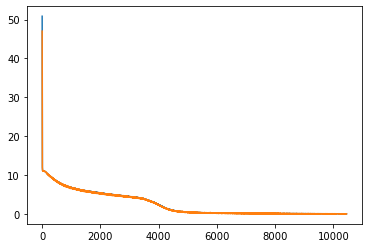

In [10]:
x = [i for i in range(len(training_history['train_loss']))]

fig, ax = plt.subplots()

line1, = ax.plot(x, training_history['train_loss'], label='train_loss')
line2, = ax.plot(x, training_history['val_loss'], label='val_loss')

plt.show()

(32, 20, 27)


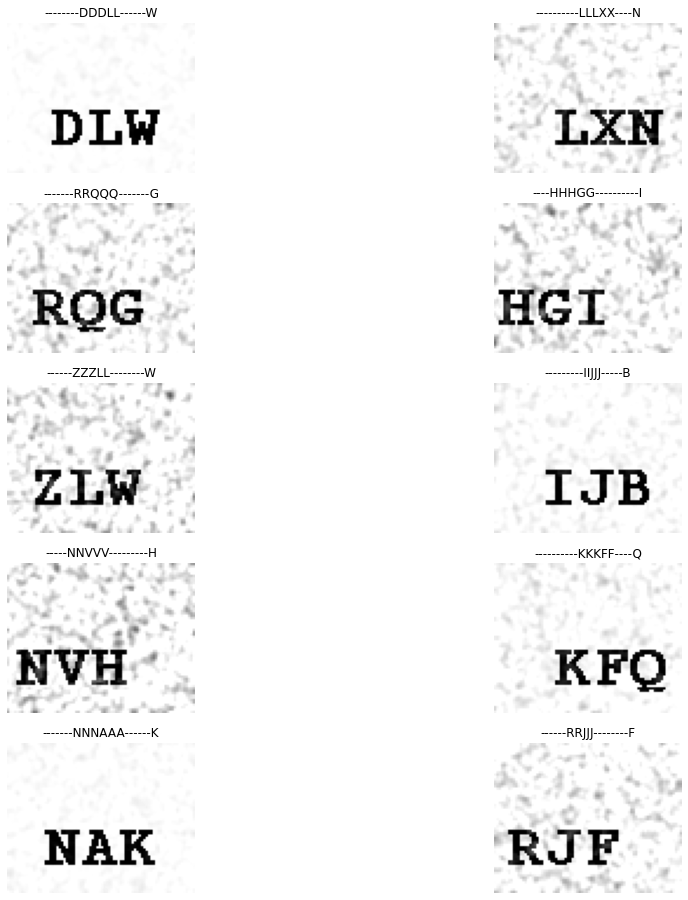

In [11]:
data = next(textgen())

pred_model.load_weights("./results/lite_seqs_model.h5")
y_pred = pred_model(data['images'], training=False)
print(y_pred.shape)

def best_path(sample):
    path = ""
    for col in sample:
        index = np.argmax(col)
        
        if index < len(alphabet):
            path = path + alphabet[index]
        else:
            path = path + "-"
        
    return path

fig, axes = plt.subplots(5, 2, figsize=(16, 16))
axes = axes.flatten()

for index in range(10):   
    axes[index].set_title(best_path(y_pred[index]))
    axes[index].imshow(np.squeeze(data['images'][index], axis=2), cmap='gray')
    axes[index].axis('off')
    
plt.show()